In [1]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import GRU,Dropout,SimpleRNN
from keras.optimizers import SGD
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
plt.rcParams.update({'figure.figsize': (18, 8), 'figure.dpi': 100})

Using TensorFlow backend.


In [2]:
%matplotlib inline
sns.set()
plt.rcParams.update({'figure.figsize': (18, 8), 'figure.dpi': 100})

In [3]:
df = pd.read_csv('iig_maitri.csv')
df.obstime = pd.to_datetime(df.obstime)
df.set_index('obstime', inplace=True)
size=df.size
orig=df
size=size-df.size
df=df[df.tempr>-100]
print(df)

                     tempr     rh     ws      wd      ap
obstime                                                 
2012-01-01 00:00:00  -1.36  56.19  10.34  233.79  976.00
2012-01-01 01:00:00  -1.37  54.99  11.34  232.24  976.00
2012-01-01 02:00:00  -1.19  53.36  10.87  236.04  975.81
2012-01-01 03:00:00  -0.56  48.94  11.76  240.23  975.00
2012-01-01 04:00:00  -1.02  53.36  13.07  234.68  975.00
2012-01-01 05:00:00  -1.19  53.75  14.32  231.56  975.00
2012-01-01 06:00:00  -0.57  51.03  13.85  234.64  974.87
2012-01-01 07:00:00  -0.33  51.59  13.65  236.77  974.00
2012-01-01 08:00:00  -0.07  52.77  12.90  235.86  974.00
2012-01-01 09:00:00   0.30  50.73  12.56  235.05  974.00
2012-01-01 10:00:00   0.74  51.18  12.60  232.95  973.15
2012-01-01 11:00:00   1.24  48.97  12.97  236.37  973.00
2012-01-01 12:00:00   1.66  50.95  11.37  236.97  972.23
2012-01-01 13:00:00   2.13  52.37  10.92  235.91  971.48
2012-01-01 14:00:00   2.38  51.18  10.65  232.94  971.00
2012-01-01 15:00:00   2.31  48.

In [4]:

#df_month = df.resample('M').mean()
#temp = df_month[['temp']]
#temp.dropna(inplace=True)

In [5]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [6]:
#df=df.last(30)
raw_values2 = df['tempr'].values
raw_values=raw_values2[:int(0.8*raw_values2.size)]
testX=raw_values2[int(0.8*raw_values2.size):]
# print(raw_values)

In [7]:
n_steps = 24
X, y = split_sequence(raw_values, n_steps)
for i in range(len(raw_values)-n_steps):
    print( X[i], y[i])
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

[-1.36 -1.37 -1.19 -0.56 -1.02 -1.19 -0.57 -0.33 -0.07  0.3   0.74  1.24
  1.66  2.13  2.38  2.31  1.96  1.72  1.17  0.69  0.29 -0.33 -0.88 -2.  ] -2.15
[-1.37 -1.19 -0.56 -1.02 -1.19 -0.57 -0.33 -0.07  0.3   0.74  1.24  1.66
  2.13  2.38  2.31  1.96  1.72  1.17  0.69  0.29 -0.33 -0.88 -2.   -2.15] -3.2
[-1.19 -0.56 -1.02 -1.19 -0.57 -0.33 -0.07  0.3   0.74  1.24  1.66  2.13
  2.38  2.31  1.96  1.72  1.17  0.69  0.29 -0.33 -0.88 -2.   -2.15 -3.2 ] -3.33
[-0.56 -1.02 -1.19 -0.57 -0.33 -0.07  0.3   0.74  1.24  1.66  2.13  2.38
  2.31  1.96  1.72  1.17  0.69  0.29 -0.33 -0.88 -2.   -2.15 -3.2  -3.33] -2.92
[-1.02 -1.19 -0.57 -0.33 -0.07  0.3   0.74  1.24  1.66  2.13  2.38  2.31
  1.96  1.72  1.17  0.69  0.29 -0.33 -0.88 -2.   -2.15 -3.2  -3.33 -2.92] -2.59
[-1.19 -0.57 -0.33 -0.07  0.3   0.74  1.24  1.66  2.13  2.38  2.31  1.96
  1.72  1.17  0.69  0.29 -0.33 -0.88 -2.   -2.15 -3.2  -3.33 -2.92 -2.59] -2.08
[-0.57 -0.33 -0.07  0.3   0.74  1.24  1.66  2.13  2.38  2.31  1.96  1.72
  1.17  0.

 -1.2  -0.98 -1.15 -0.85  0.15  0.93  1.83  2.52  2.83  2.66  1.92  1.97] 1.77
[ 2.62  2.08  1.91  1.35  0.67  0.88  0.18 -0.64 -0.88 -0.37 -0.48 -1.2
 -0.98 -1.15 -0.85  0.15  0.93  1.83  2.52  2.83  2.66  1.92  1.97  1.77] 2.51
[ 2.08  1.91  1.35  0.67  0.88  0.18 -0.64 -0.88 -0.37 -0.48 -1.2  -0.98
 -1.15 -0.85  0.15  0.93  1.83  2.52  2.83  2.66  1.92  1.97  1.77  2.51] 1.64
[ 1.91  1.35  0.67  0.88  0.18 -0.64 -0.88 -0.37 -0.48 -1.2  -0.98 -1.15
 -0.85  0.15  0.93  1.83  2.52  2.83  2.66  1.92  1.97  1.77  2.51  1.64] 0.81
[ 1.35  0.67  0.88  0.18 -0.64 -0.88 -0.37 -0.48 -1.2  -0.98 -1.15 -0.85
  0.15  0.93  1.83  2.52  2.83  2.66  1.92  1.97  1.77  2.51  1.64  0.81] 0.98
[ 0.67  0.88  0.18 -0.64 -0.88 -0.37 -0.48 -1.2  -0.98 -1.15 -0.85  0.15
  0.93  1.83  2.52  2.83  2.66  1.92  1.97  1.77  2.51  1.64  0.81  0.98] 0.05
[ 0.88  0.18 -0.64 -0.88 -0.37 -0.48 -1.2  -0.98 -1.15 -0.85  0.15  0.93
  1.83  2.52  2.83  2.66  1.92  1.97  1.77  2.51  1.64  0.81  0.98  0.05] 0.77
[ 0.18 -0.

  1.21  0.97  0.73  0.32 -0.17 -0.66 -1.3  -1.87 -2.53 -3.12 -3.78 -4.08] -4.45
[-1.94 -1.33 -0.92 -0.77  0.41  1.49  1.91  2.16  2.49  2.19  1.51  1.21
  0.97  0.73  0.32 -0.17 -0.66 -1.3  -1.87 -2.53 -3.12 -3.78 -4.08 -4.45] -4.09
[-1.33 -0.92 -0.77  0.41  1.49  1.91  2.16  2.49  2.19  1.51  1.21  0.97
  0.73  0.32 -0.17 -0.66 -1.3  -1.87 -2.53 -3.12 -3.78 -4.08 -4.45 -4.09] -3.43
[-0.92 -0.77  0.41  1.49  1.91  2.16  2.49  2.19  1.51  1.21  0.97  0.73
  0.32 -0.17 -0.66 -1.3  -1.87 -2.53 -3.12 -3.78 -4.08 -4.45 -4.09 -3.43] -2.71
[-0.77  0.41  1.49  1.91  2.16  2.49  2.19  1.51  1.21  0.97  0.73  0.32
 -0.17 -0.66 -1.3  -1.87 -2.53 -3.12 -3.78 -4.08 -4.45 -4.09 -3.43 -2.71] -1.77
[ 0.41  1.49  1.91  2.16  2.49  2.19  1.51  1.21  0.97  0.73  0.32 -0.17
 -0.66 -1.3  -1.87 -2.53 -3.12 -3.78 -4.08 -4.45 -4.09 -3.43 -2.71 -1.77] -1.0
[ 1.49  1.91  2.16  2.49  2.19  1.51  1.21  0.97  0.73  0.32 -0.17 -0.66
 -1.3  -1.87 -2.53 -3.12 -3.78 -4.08 -4.45 -4.09 -3.43 -2.71 -1.77 -1.  ] -0.24
[ 1

 -2.47 -3.66 -3.68 -3.79 -2.8  -2.05 -1.12 -0.39 -0.91 -0.46  0.19  0.54] 0.46
[ 1.05  0.62  0.72  0.12 -0.5  -0.99 -1.55 -1.64 -1.72 -1.52 -1.91 -2.47
 -3.66 -3.68 -3.79 -2.8  -2.05 -1.12 -0.39 -0.91 -0.46  0.19  0.54  0.46] 0.32
[ 0.62  0.72  0.12 -0.5  -0.99 -1.55 -1.64 -1.72 -1.52 -1.91 -2.47 -3.66
 -3.68 -3.79 -2.8  -2.05 -1.12 -0.39 -0.91 -0.46  0.19  0.54  0.46  0.32] -0.19
[ 0.72  0.12 -0.5  -0.99 -1.55 -1.64 -1.72 -1.52 -1.91 -2.47 -3.66 -3.68
 -3.79 -2.8  -2.05 -1.12 -0.39 -0.91 -0.46  0.19  0.54  0.46  0.32 -0.19] -0.69
[ 0.12 -0.5  -0.99 -1.55 -1.64 -1.72 -1.52 -1.91 -2.47 -3.66 -3.68 -3.79
 -2.8  -2.05 -1.12 -0.39 -0.91 -0.46  0.19  0.54  0.46  0.32 -0.19 -0.69] -0.96
[-0.5  -0.99 -1.55 -1.64 -1.72 -1.52 -1.91 -2.47 -3.66 -3.68 -3.79 -2.8
 -2.05 -1.12 -0.39 -0.91 -0.46  0.19  0.54  0.46  0.32 -0.19 -0.69 -0.96] -1.14
[-0.99 -1.55 -1.64 -1.72 -1.52 -1.91 -2.47 -3.66 -3.68 -3.79 -2.8  -2.05
 -1.12 -0.39 -0.91 -0.46  0.19  0.54  0.46  0.32 -0.19 -0.69 -0.96 -1.14] -1.39
[-1.5

 -6.98 -6.81 -6.64 -6.6  -6.59 -6.6  -6.62 -6.69 -6.75 -6.71 -6.67 -6.55] -6.49
[-6.82 -6.72 -7.   -7.49 -7.46 -7.17 -7.11 -6.99 -6.99 -6.99 -7.04 -6.98
 -6.81 -6.64 -6.6  -6.59 -6.6  -6.62 -6.69 -6.75 -6.71 -6.67 -6.55 -6.49] -6.39
[-6.72 -7.   -7.49 -7.46 -7.17 -7.11 -6.99 -6.99 -6.99 -7.04 -6.98 -6.81
 -6.64 -6.6  -6.59 -6.6  -6.62 -6.69 -6.75 -6.71 -6.67 -6.55 -6.49 -6.39] -6.24
[-7.   -7.49 -7.46 -7.17 -7.11 -6.99 -6.99 -6.99 -7.04 -6.98 -6.81 -6.64
 -6.6  -6.59 -6.6  -6.62 -6.69 -6.75 -6.71 -6.67 -6.55 -6.49 -6.39 -6.24] -6.02
[-7.49 -7.46 -7.17 -7.11 -6.99 -6.99 -6.99 -7.04 -6.98 -6.81 -6.64 -6.6
 -6.59 -6.6  -6.62 -6.69 -6.75 -6.71 -6.67 -6.55 -6.49 -6.39 -6.24 -6.02] -5.77
[-7.46 -7.17 -7.11 -6.99 -6.99 -6.99 -7.04 -6.98 -6.81 -6.64 -6.6  -6.59
 -6.6  -6.62 -6.69 -6.75 -6.71 -6.67 -6.55 -6.49 -6.39 -6.24 -6.02 -5.77] -5.67
[-7.17 -7.11 -6.99 -6.99 -6.99 -7.04 -6.98 -6.81 -6.64 -6.6  -6.59 -6.6
 -6.62 -6.69 -6.75 -6.71 -6.67 -6.55 -6.49 -6.39 -6.24 -6.02 -5.77 -5.67] -5.63
[-7.

 -3.77 -4.   -4.05 -3.81 -3.76 -3.73 -3.73 -3.88 -3.79 -4.23 -4.59 -4.56] -4.56
[-4.7  -4.89 -4.75 -4.73 -4.66 -4.5  -4.62 -4.62 -4.   -3.85 -3.72 -3.77
 -4.   -4.05 -3.81 -3.76 -3.73 -3.73 -3.88 -3.79 -4.23 -4.59 -4.56 -4.56] -4.95
[-4.89 -4.75 -4.73 -4.66 -4.5  -4.62 -4.62 -4.   -3.85 -3.72 -3.77 -4.
 -4.05 -3.81 -3.76 -3.73 -3.73 -3.88 -3.79 -4.23 -4.59 -4.56 -4.56 -4.95] -5.1
[-4.75 -4.73 -4.66 -4.5  -4.62 -4.62 -4.   -3.85 -3.72 -3.77 -4.   -4.05
 -3.81 -3.76 -3.73 -3.73 -3.88 -3.79 -4.23 -4.59 -4.56 -4.56 -4.95 -5.1 ] -5.65
[-4.73 -4.66 -4.5  -4.62 -4.62 -4.   -3.85 -3.72 -3.77 -4.   -4.05 -3.81
 -3.76 -3.73 -3.73 -3.88 -3.79 -4.23 -4.59 -4.56 -4.56 -4.95 -5.1  -5.65] -6.05
[-4.66 -4.5  -4.62 -4.62 -4.   -3.85 -3.72 -3.77 -4.   -4.05 -3.81 -3.76
 -3.73 -3.73 -3.88 -3.79 -4.23 -4.59 -4.56 -4.56 -4.95 -5.1  -5.65 -6.05] -5.92
[-4.5  -4.62 -4.62 -4.   -3.85 -3.72 -3.77 -4.   -4.05 -3.81 -3.76 -3.73
 -3.73 -3.88 -3.79 -4.23 -4.59 -4.56 -4.56 -4.95 -5.1  -5.65 -6.05 -5.92] -5.84
[-4.6

 -4.63 -4.55 -4.19 -3.7  -3.78 -4.06 -3.7  -4.07 -4.71 -5.88 -6.31 -6.22] -6.6
[-5.62 -5.92 -5.9  -5.54 -5.7  -5.47 -4.83 -4.8  -4.78 -4.81 -4.8  -4.63
 -4.55 -4.19 -3.7  -3.78 -4.06 -3.7  -4.07 -4.71 -5.88 -6.31 -6.22 -6.6 ] -6.14
[-5.92 -5.9  -5.54 -5.7  -5.47 -4.83 -4.8  -4.78 -4.81 -4.8  -4.63 -4.55
 -4.19 -3.7  -3.78 -4.06 -3.7  -4.07 -4.71 -5.88 -6.31 -6.22 -6.6  -6.14] -5.94
[-5.9  -5.54 -5.7  -5.47 -4.83 -4.8  -4.78 -4.81 -4.8  -4.63 -4.55 -4.19
 -3.7  -3.78 -4.06 -3.7  -4.07 -4.71 -5.88 -6.31 -6.22 -6.6  -6.14 -5.94] -5.9
[-5.54 -5.7  -5.47 -4.83 -4.8  -4.78 -4.81 -4.8  -4.63 -4.55 -4.19 -3.7
 -3.78 -4.06 -3.7  -4.07 -4.71 -5.88 -6.31 -6.22 -6.6  -6.14 -5.94 -5.9 ] -6.09
[-5.7  -5.47 -4.83 -4.8  -4.78 -4.81 -4.8  -4.63 -4.55 -4.19 -3.7  -3.78
 -4.06 -3.7  -4.07 -4.71 -5.88 -6.31 -6.22 -6.6  -6.14 -5.94 -5.9  -6.09] -5.97
[-5.47 -4.83 -4.8  -4.78 -4.81 -4.8  -4.63 -4.55 -4.19 -3.7  -3.78 -4.06
 -3.7  -4.07 -4.71 -5.88 -6.31 -6.22 -6.6  -6.14 -5.94 -5.9  -6.09 -5.97] -6.0
[-4.83

 -12.37 -12.74 -12.14  -9.79] -8.76
[ -7.99  -6.31  -4.89  -4.14  -4.01  -2.99  -2.43  -4.01  -6.49  -6.97
  -7.69  -9.03 -10.11 -10.95 -11.66 -12.16 -11.87 -13.27 -12.5  -12.37
 -12.74 -12.14  -9.79  -8.76] -8.49
[ -6.31  -4.89  -4.14  -4.01  -2.99  -2.43  -4.01  -6.49  -6.97  -7.69
  -9.03 -10.11 -10.95 -11.66 -12.16 -11.87 -13.27 -12.5  -12.37 -12.74
 -12.14  -9.79  -8.76  -8.49] -7.96
[ -4.89  -4.14  -4.01  -2.99  -2.43  -4.01  -6.49  -6.97  -7.69  -9.03
 -10.11 -10.95 -11.66 -12.16 -11.87 -13.27 -12.5  -12.37 -12.74 -12.14
  -9.79  -8.76  -8.49  -7.96] -7.43
[ -4.14  -4.01  -2.99  -2.43  -4.01  -6.49  -6.97  -7.69  -9.03 -10.11
 -10.95 -11.66 -12.16 -11.87 -13.27 -12.5  -12.37 -12.74 -12.14  -9.79
  -8.76  -8.49  -7.96  -7.43] -7.14
[ -4.01  -2.99  -2.43  -4.01  -6.49  -6.97  -7.69  -9.03 -10.11 -10.95
 -11.66 -12.16 -11.87 -13.27 -12.5  -12.37 -12.74 -12.14  -9.79  -8.76
  -8.49  -7.96  -7.43  -7.14] -8.3
[ -2.99  -2.43  -4.01  -6.49  -6.97  -7.69  -9.03 -10.11 -10.95 -11.66
 -12

 -5.19 -5.44 -6.33 -6.77 -6.72 -7.02 -7.3  -7.32 -7.19 -7.05 -6.96 -7.43] -7.34
[-7.87 -8.4  -6.86 -6.13 -5.62 -5.14 -5.39 -5.42 -5.15 -4.78 -4.1  -5.19
 -5.44 -6.33 -6.77 -6.72 -7.02 -7.3  -7.32 -7.19 -7.05 -6.96 -7.43 -7.34] -7.69
[-8.4  -6.86 -6.13 -5.62 -5.14 -5.39 -5.42 -5.15 -4.78 -4.1  -5.19 -5.44
 -6.33 -6.77 -6.72 -7.02 -7.3  -7.32 -7.19 -7.05 -6.96 -7.43 -7.34 -7.69] -8.07
[-6.86 -6.13 -5.62 -5.14 -5.39 -5.42 -5.15 -4.78 -4.1  -5.19 -5.44 -6.33
 -6.77 -6.72 -7.02 -7.3  -7.32 -7.19 -7.05 -6.96 -7.43 -7.34 -7.69 -8.07] -8.72
[-6.13 -5.62 -5.14 -5.39 -5.42 -5.15 -4.78 -4.1  -5.19 -5.44 -6.33 -6.77
 -6.72 -7.02 -7.3  -7.32 -7.19 -7.05 -6.96 -7.43 -7.34 -7.69 -8.07 -8.72] -8.68
[-5.62 -5.14 -5.39 -5.42 -5.15 -4.78 -4.1  -5.19 -5.44 -6.33 -6.77 -6.72
 -7.02 -7.3  -7.32 -7.19 -7.05 -6.96 -7.43 -7.34 -7.69 -8.07 -8.72 -8.68] -8.96
[-5.14 -5.39 -5.42 -5.15 -4.78 -4.1  -5.19 -5.44 -6.33 -6.77 -6.72 -7.02
 -7.3  -7.32 -7.19 -7.05 -6.96 -7.43 -7.34 -7.69 -8.07 -8.72 -8.68 -8.96] -8.37
[-

 -15.76 -15.23 -14.71 -14.26] -13.35
[-11.98 -11.67 -11.85 -12.35 -12.51 -13.12 -13.79 -14.36 -14.52 -14.71
 -14.8  -14.98 -15.12 -15.12 -15.32 -15.63 -15.83 -15.92 -15.91 -15.76
 -15.23 -14.71 -14.26 -13.35] -12.88
[-11.67 -11.85 -12.35 -12.51 -13.12 -13.79 -14.36 -14.52 -14.71 -14.8
 -14.98 -15.12 -15.12 -15.32 -15.63 -15.83 -15.92 -15.91 -15.76 -15.23
 -14.71 -14.26 -13.35 -12.88] -12.78
[-11.85 -12.35 -12.51 -13.12 -13.79 -14.36 -14.52 -14.71 -14.8  -14.98
 -15.12 -15.12 -15.32 -15.63 -15.83 -15.92 -15.91 -15.76 -15.23 -14.71
 -14.26 -13.35 -12.88 -12.78] -12.69
[-12.35 -12.51 -13.12 -13.79 -14.36 -14.52 -14.71 -14.8  -14.98 -15.12
 -15.12 -15.32 -15.63 -15.83 -15.92 -15.91 -15.76 -15.23 -14.71 -14.26
 -13.35 -12.88 -12.78 -12.69] -13.25
[-12.51 -13.12 -13.79 -14.36 -14.52 -14.71 -14.8  -14.98 -15.12 -15.12
 -15.32 -15.63 -15.83 -15.92 -15.91 -15.76 -15.23 -14.71 -14.26 -13.35
 -12.88 -12.78 -12.69 -13.25] -13.92
[-13.12 -13.79 -14.36 -14.52 -14.71 -14.8  -14.98 -15.12 -15.12 -15.3

[-11.16 -11.13 -11.16 -10.68 -10.33 -10.6  -11.37 -12.23 -12.71 -11.73
 -10.95 -11.81 -11.66 -12.97 -13.26 -12.8  -12.27 -11.28 -10.74 -10.89
 -10.34 -11.15 -11.21 -12.16] -11.86
[-11.13 -11.16 -10.68 -10.33 -10.6  -11.37 -12.23 -12.71 -11.73 -10.95
 -11.81 -11.66 -12.97 -13.26 -12.8  -12.27 -11.28 -10.74 -10.89 -10.34
 -11.15 -11.21 -12.16 -11.86] -11.38
[-11.16 -10.68 -10.33 -10.6  -11.37 -12.23 -12.71 -11.73 -10.95 -11.81
 -11.66 -12.97 -13.26 -12.8  -12.27 -11.28 -10.74 -10.89 -10.34 -11.15
 -11.21 -12.16 -11.86 -11.38] -11.08
[-10.68 -10.33 -10.6  -11.37 -12.23 -12.71 -11.73 -10.95 -11.81 -11.66
 -12.97 -13.26 -12.8  -12.27 -11.28 -10.74 -10.89 -10.34 -11.15 -11.21
 -12.16 -11.86 -11.38 -11.08] -11.06
[-10.33 -10.6  -11.37 -12.23 -12.71 -11.73 -10.95 -11.81 -11.66 -12.97
 -13.26 -12.8  -12.27 -11.28 -10.74 -10.89 -10.34 -11.15 -11.21 -12.16
 -11.86 -11.38 -11.08 -11.06] -11.13
[-10.6  -11.37 -12.23 -12.71 -11.73 -10.95 -11.81 -11.66 -12.97 -13.26
 -12.8  -12.27 -11.28 -10.74 -10.8

 -17.04 -17.7  -18.62 -17.12] -16.91
[-14.31 -15.46 -14.96 -15.04 -16.3  -16.86 -16.71 -15.98 -17.07 -17.45
 -17.28 -15.63 -16.17 -15.07 -15.3  -15.54 -16.85 -17.09 -16.9  -17.04
 -17.7  -18.62 -17.12 -16.91] -16.51
[-15.46 -14.96 -15.04 -16.3  -16.86 -16.71 -15.98 -17.07 -17.45 -17.28
 -15.63 -16.17 -15.07 -15.3  -15.54 -16.85 -17.09 -16.9  -17.04 -17.7
 -18.62 -17.12 -16.91 -16.51] -16.27
[-14.96 -15.04 -16.3  -16.86 -16.71 -15.98 -17.07 -17.45 -17.28 -15.63
 -16.17 -15.07 -15.3  -15.54 -16.85 -17.09 -16.9  -17.04 -17.7  -18.62
 -17.12 -16.91 -16.51 -16.27] -16.18
[-15.04 -16.3  -16.86 -16.71 -15.98 -17.07 -17.45 -17.28 -15.63 -16.17
 -15.07 -15.3  -15.54 -16.85 -17.09 -16.9  -17.04 -17.7  -18.62 -17.12
 -16.91 -16.51 -16.27 -16.18] -14.95
[-16.3  -16.86 -16.71 -15.98 -17.07 -17.45 -17.28 -15.63 -16.17 -15.07
 -15.3  -15.54 -16.85 -17.09 -16.9  -17.04 -17.7  -18.62 -17.12 -16.91
 -16.51 -16.27 -16.18 -14.95] -14.74
[-16.86 -16.71 -15.98 -17.07 -17.45 -17.28 -15.63 -16.17 -15.07 -15.3

 -10.94 -11.42 -10.02 -11.17] -9.5
[ -9.32  -9.42  -9.56  -9.03  -8.92  -8.65  -8.8   -8.42  -8.5   -8.8
  -9.58  -9.68  -9.15  -9.3   -9.97 -10.28 -11.55 -10.84 -10.54 -10.94
 -11.42 -10.02 -11.17  -9.5 ] -11.74
[ -9.42  -9.56  -9.03  -8.92  -8.65  -8.8   -8.42  -8.5   -8.8   -9.58
  -9.68  -9.15  -9.3   -9.97 -10.28 -11.55 -10.84 -10.54 -10.94 -11.42
 -10.02 -11.17  -9.5  -11.74] -12.8
[ -9.56  -9.03  -8.92  -8.65  -8.8   -8.42  -8.5   -8.8   -9.58  -9.68
  -9.15  -9.3   -9.97 -10.28 -11.55 -10.84 -10.54 -10.94 -11.42 -10.02
 -11.17  -9.5  -11.74 -12.8 ] -11.65
[ -9.03  -8.92  -8.65  -8.8   -8.42  -8.5   -8.8   -9.58  -9.68  -9.15
  -9.3   -9.97 -10.28 -11.55 -10.84 -10.54 -10.94 -11.42 -10.02 -11.17
  -9.5  -11.74 -12.8  -11.65] -12.33
[ -8.92  -8.65  -8.8   -8.42  -8.5   -8.8   -9.58  -9.68  -9.15  -9.3
  -9.97 -10.28 -11.55 -10.84 -10.54 -10.94 -11.42 -10.02 -11.17  -9.5
 -11.74 -12.8  -11.65 -12.33] -10.69
[ -8.65  -8.8   -8.42  -8.5   -8.8   -9.58  -9.68  -9.15  -9.3   -9.97
 -1

 -14.69 -14.17 -14.76 -14.61] -15.09
[ -9.26  -8.79  -8.95  -9.61  -9.53  -9.62  -9.82 -12.16 -14.02 -14.72
 -12.58 -11.81 -12.53 -13.31 -13.6  -14.38 -14.73 -15.   -14.8  -14.69
 -14.17 -14.76 -14.61 -15.09] -15.44
[ -8.79  -8.95  -9.61  -9.53  -9.62  -9.82 -12.16 -14.02 -14.72 -12.58
 -11.81 -12.53 -13.31 -13.6  -14.38 -14.73 -15.   -14.8  -14.69 -14.17
 -14.76 -14.61 -15.09 -15.44] -15.77
[ -8.95  -9.61  -9.53  -9.62  -9.82 -12.16 -14.02 -14.72 -12.58 -11.81
 -12.53 -13.31 -13.6  -14.38 -14.73 -15.   -14.8  -14.69 -14.17 -14.76
 -14.61 -15.09 -15.44 -15.77] -15.78
[ -9.61  -9.53  -9.62  -9.82 -12.16 -14.02 -14.72 -12.58 -11.81 -12.53
 -13.31 -13.6  -14.38 -14.73 -15.   -14.8  -14.69 -14.17 -14.76 -14.61
 -15.09 -15.44 -15.77 -15.78] -16.85
[ -9.53  -9.62  -9.82 -12.16 -14.02 -14.72 -12.58 -11.81 -12.53 -13.31
 -13.6  -14.38 -14.73 -15.   -14.8  -14.69 -14.17 -14.76 -14.61 -15.09
 -15.44 -15.77 -15.78 -16.85] -17.3
[ -9.62  -9.82 -12.16 -14.02 -14.72 -12.58 -11.81 -12.53 -13.31 -13.6

 -15.9  -14.18 -12.89 -12.07] -12.22
[-23.51 -23.43 -24.62 -25.92 -25.94 -25.89 -26.18 -26.78 -26.07 -25.55
 -25.04 -24.63 -24.33 -23.55 -20.33 -20.91 -20.06 -15.6  -14.94 -15.9
 -14.18 -12.89 -12.07 -12.22] -13.08
[-23.43 -24.62 -25.92 -25.94 -25.89 -26.18 -26.78 -26.07 -25.55 -25.04
 -24.63 -24.33 -23.55 -20.33 -20.91 -20.06 -15.6  -14.94 -15.9  -14.18
 -12.89 -12.07 -12.22 -13.08] -14.21
[-24.62 -25.92 -25.94 -25.89 -26.18 -26.78 -26.07 -25.55 -25.04 -24.63
 -24.33 -23.55 -20.33 -20.91 -20.06 -15.6  -14.94 -15.9  -14.18 -12.89
 -12.07 -12.22 -13.08 -14.21] -15.74
[-25.92 -25.94 -25.89 -26.18 -26.78 -26.07 -25.55 -25.04 -24.63 -24.33
 -23.55 -20.33 -20.91 -20.06 -15.6  -14.94 -15.9  -14.18 -12.89 -12.07
 -12.22 -13.08 -14.21 -15.74] -17.19
[-25.94 -25.89 -26.18 -26.78 -26.07 -25.55 -25.04 -24.63 -24.33 -23.55
 -20.33 -20.91 -20.06 -15.6  -14.94 -15.9  -14.18 -12.89 -12.07 -12.22
 -13.08 -14.21 -15.74 -17.19] -17.41
[-25.89 -26.18 -26.78 -26.07 -25.55 -25.04 -24.63 -24.33 -23.55 -20.3

 -14.67 -14.86 -12.8  -13.22] -13.52
[-19.53 -20.56 -20.81 -19.49 -20.42 -20.14 -19.81 -18.6  -17.24 -17.37
 -17.83 -16.79 -17.64 -16.79 -19.8  -17.85 -18.39 -18.6  -16.78 -14.67
 -14.86 -12.8  -13.22 -13.52] -14.43
[-20.56 -20.81 -19.49 -20.42 -20.14 -19.81 -18.6  -17.24 -17.37 -17.83
 -16.79 -17.64 -16.79 -19.8  -17.85 -18.39 -18.6  -16.78 -14.67 -14.86
 -12.8  -13.22 -13.52 -14.43] -14.46
[-20.81 -19.49 -20.42 -20.14 -19.81 -18.6  -17.24 -17.37 -17.83 -16.79
 -17.64 -16.79 -19.8  -17.85 -18.39 -18.6  -16.78 -14.67 -14.86 -12.8
 -13.22 -13.52 -14.43 -14.46] -15.11
[-19.49 -20.42 -20.14 -19.81 -18.6  -17.24 -17.37 -17.83 -16.79 -17.64
 -16.79 -19.8  -17.85 -18.39 -18.6  -16.78 -14.67 -14.86 -12.8  -13.22
 -13.52 -14.43 -14.46 -15.11] -15.35
[-20.42 -20.14 -19.81 -18.6  -17.24 -17.37 -17.83 -16.79 -17.64 -16.79
 -19.8  -17.85 -18.39 -18.6  -16.78 -14.67 -14.86 -12.8  -13.22 -13.52
 -14.43 -14.46 -15.11 -15.35] -16.19
[-20.14 -19.81 -18.6  -17.24 -17.37 -17.83 -16.79 -17.64 -16.79 -19.8

 -24.69 -24.47 -23.8  -23.48] -25.35
[-24.75 -24.02 -25.4  -24.63 -22.43 -22.76 -23.56 -22.83 -23.42 -24.25
 -24.45 -24.85 -24.71 -24.26 -23.85 -23.29 -25.27 -25.47 -24.21 -24.69
 -24.47 -23.8  -23.48 -25.35] -23.77
[-24.02 -25.4  -24.63 -22.43 -22.76 -23.56 -22.83 -23.42 -24.25 -24.45
 -24.85 -24.71 -24.26 -23.85 -23.29 -25.27 -25.47 -24.21 -24.69 -24.47
 -23.8  -23.48 -25.35 -23.77] -19.75
[-25.4  -24.63 -22.43 -22.76 -23.56 -22.83 -23.42 -24.25 -24.45 -24.85
 -24.71 -24.26 -23.85 -23.29 -25.27 -25.47 -24.21 -24.69 -24.47 -23.8
 -23.48 -25.35 -23.77 -19.75] -20.69
[-24.63 -22.43 -22.76 -23.56 -22.83 -23.42 -24.25 -24.45 -24.85 -24.71
 -24.26 -23.85 -23.29 -25.27 -25.47 -24.21 -24.69 -24.47 -23.8  -23.48
 -25.35 -23.77 -19.75 -20.69] -18.75
[-22.43 -22.76 -23.56 -22.83 -23.42 -24.25 -24.45 -24.85 -24.71 -24.26
 -23.85 -23.29 -25.27 -25.47 -24.21 -24.69 -24.47 -23.8  -23.48 -25.35
 -23.77 -19.75 -20.69 -18.75] -17.0
[-22.76 -23.56 -22.83 -23.42 -24.25 -24.45 -24.85 -24.71 -24.26 -23.85

[-18.07 -18.28 -18.33 -18.24 -18.25 -18.71 -18.89 -18.75 -18.82 -19.49
 -19.62 -19.92 -19.46 -19.21 -19.3  -19.46 -19.72 -19.91 -19.72 -19.47
 -20.02 -19.82 -19.34 -19.1 ] -19.52
[-18.28 -18.33 -18.24 -18.25 -18.71 -18.89 -18.75 -18.82 -19.49 -19.62
 -19.92 -19.46 -19.21 -19.3  -19.46 -19.72 -19.91 -19.72 -19.47 -20.02
 -19.82 -19.34 -19.1  -19.52] -20.02
[-18.33 -18.24 -18.25 -18.71 -18.89 -18.75 -18.82 -19.49 -19.62 -19.92
 -19.46 -19.21 -19.3  -19.46 -19.72 -19.91 -19.72 -19.47 -20.02 -19.82
 -19.34 -19.1  -19.52 -20.02] -20.34
[-18.24 -18.25 -18.71 -18.89 -18.75 -18.82 -19.49 -19.62 -19.92 -19.46
 -19.21 -19.3  -19.46 -19.72 -19.91 -19.72 -19.47 -20.02 -19.82 -19.34
 -19.1  -19.52 -20.02 -20.34] -20.67
[-18.25 -18.71 -18.89 -18.75 -18.82 -19.49 -19.62 -19.92 -19.46 -19.21
 -19.3  -19.46 -19.72 -19.91 -19.72 -19.47 -20.02 -19.82 -19.34 -19.1
 -19.52 -20.02 -20.34 -20.67] -21.05
[-18.71 -18.89 -18.75 -18.82 -19.49 -19.62 -19.92 -19.46 -19.21 -19.3
 -19.46 -19.72 -19.91 -19.72 -19.47 

 -14.22 -14.66 -14.97 -15.2 ] -15.41
[-16.59 -16.83 -16.84 -16.51 -16.48 -16.35 -16.13 -15.84 -15.64 -15.9
 -15.76 -15.69 -15.39 -15.28 -15.28 -15.14 -14.86 -14.56 -14.06 -14.22
 -14.66 -14.97 -15.2  -15.41] -15.94
[-16.83 -16.84 -16.51 -16.48 -16.35 -16.13 -15.84 -15.64 -15.9  -15.76
 -15.69 -15.39 -15.28 -15.28 -15.14 -14.86 -14.56 -14.06 -14.22 -14.66
 -14.97 -15.2  -15.41 -15.94] -16.13
[-16.84 -16.51 -16.48 -16.35 -16.13 -15.84 -15.64 -15.9  -15.76 -15.69
 -15.39 -15.28 -15.28 -15.14 -14.86 -14.56 -14.06 -14.22 -14.66 -14.97
 -15.2  -15.41 -15.94 -16.13] -15.84
[-16.51 -16.48 -16.35 -16.13 -15.84 -15.64 -15.9  -15.76 -15.69 -15.39
 -15.28 -15.28 -15.14 -14.86 -14.56 -14.06 -14.22 -14.66 -14.97 -15.2
 -15.41 -15.94 -16.13 -15.84] -16.03
[-16.48 -16.35 -16.13 -15.84 -15.64 -15.9  -15.76 -15.69 -15.39 -15.28
 -15.28 -15.14 -14.86 -14.56 -14.06 -14.22 -14.66 -14.97 -15.2  -15.41
 -15.94 -16.13 -15.84 -16.03] -15.74
[-16.35 -16.13 -15.84 -15.64 -15.9  -15.76 -15.69 -15.39 -15.28 -15.28

 -12.1  -12.27 -12.27 -12.05] -11.64
[-22.   -21.45 -20.85 -20.01 -19.14 -18.47 -17.82 -17.17 -16.64 -15.95
 -15.33 -14.61 -13.9  -13.43 -13.19 -12.7  -12.17 -11.97 -12.11 -12.1
 -12.27 -12.27 -12.05 -11.64] -10.8
[-21.45 -20.85 -20.01 -19.14 -18.47 -17.82 -17.17 -16.64 -15.95 -15.33
 -14.61 -13.9  -13.43 -13.19 -12.7  -12.17 -11.97 -12.11 -12.1  -12.27
 -12.27 -12.05 -11.64 -10.8 ] -10.46
[-20.85 -20.01 -19.14 -18.47 -17.82 -17.17 -16.64 -15.95 -15.33 -14.61
 -13.9  -13.43 -13.19 -12.7  -12.17 -11.97 -12.11 -12.1  -12.27 -12.27
 -12.05 -11.64 -10.8  -10.46] -10.51
[-20.01 -19.14 -18.47 -17.82 -17.17 -16.64 -15.95 -15.33 -14.61 -13.9
 -13.43 -13.19 -12.7  -12.17 -11.97 -12.11 -12.1  -12.27 -12.27 -12.05
 -11.64 -10.8  -10.46 -10.51] -10.68
[-19.14 -18.47 -17.82 -17.17 -16.64 -15.95 -15.33 -14.61 -13.9  -13.43
 -13.19 -12.7  -12.17 -11.97 -12.11 -12.1  -12.27 -12.27 -12.05 -11.64
 -10.8  -10.46 -10.51 -10.68] -12.02
[-18.47 -17.82 -17.17 -16.64 -15.95 -15.33 -14.61 -13.9  -13.43 -13.19


 -15.33 -14.75 -14.08 -13.44] -12.78
[-21.99 -21.96 -21.96 -21.82 -21.93 -21.85 -21.63 -21.6  -21.53 -21.13
 -20.33 -19.78 -18.83 -17.94 -17.58 -17.3  -17.36 -16.71 -16.01 -15.33
 -14.75 -14.08 -13.44 -12.78] -11.94
[-21.96 -21.96 -21.82 -21.93 -21.85 -21.63 -21.6  -21.53 -21.13 -20.33
 -19.78 -18.83 -17.94 -17.58 -17.3  -17.36 -16.71 -16.01 -15.33 -14.75
 -14.08 -13.44 -12.78 -11.94] -11.61
[-21.96 -21.82 -21.93 -21.85 -21.63 -21.6  -21.53 -21.13 -20.33 -19.78
 -18.83 -17.94 -17.58 -17.3  -17.36 -16.71 -16.01 -15.33 -14.75 -14.08
 -13.44 -12.78 -11.94 -11.61] -11.54
[-21.82 -21.93 -21.85 -21.63 -21.6  -21.53 -21.13 -20.33 -19.78 -18.83
 -17.94 -17.58 -17.3  -17.36 -16.71 -16.01 -15.33 -14.75 -14.08 -13.44
 -12.78 -11.94 -11.61 -11.54] -11.06
[-21.93 -21.85 -21.63 -21.6  -21.53 -21.13 -20.33 -19.78 -18.83 -17.94
 -17.58 -17.3  -17.36 -16.71 -16.01 -15.33 -14.75 -14.08 -13.44 -12.78
 -11.94 -11.61 -11.54 -11.06] -11.52
[-21.85 -21.63 -21.6  -21.53 -21.13 -20.33 -19.78 -18.83 -17.94 -17.

 -11.94 -12.18 -12.36 -12.19] -11.94
[-11.91 -11.84 -11.97 -12.41 -12.31 -11.98 -11.7  -11.5  -11.39 -11.41
 -11.32 -11.2  -10.85 -10.09 -10.08 -10.24 -10.42 -10.89 -11.56 -11.94
 -12.18 -12.36 -12.19 -11.94] -11.81
[-11.84 -11.97 -12.41 -12.31 -11.98 -11.7  -11.5  -11.39 -11.41 -11.32
 -11.2  -10.85 -10.09 -10.08 -10.24 -10.42 -10.89 -11.56 -11.94 -12.18
 -12.36 -12.19 -11.94 -11.81] -11.66
[-11.97 -12.41 -12.31 -11.98 -11.7  -11.5  -11.39 -11.41 -11.32 -11.2
 -10.85 -10.09 -10.08 -10.24 -10.42 -10.89 -11.56 -11.94 -12.18 -12.36
 -12.19 -11.94 -11.81 -11.66] -11.31
[-12.41 -12.31 -11.98 -11.7  -11.5  -11.39 -11.41 -11.32 -11.2  -10.85
 -10.09 -10.08 -10.24 -10.42 -10.89 -11.56 -11.94 -12.18 -12.36 -12.19
 -11.94 -11.81 -11.66 -11.31] -11.28
[-12.31 -11.98 -11.7  -11.5  -11.39 -11.41 -11.32 -11.2  -10.85 -10.09
 -10.08 -10.24 -10.42 -10.89 -11.56 -11.94 -12.18 -12.36 -12.19 -11.94
 -11.81 -11.66 -11.31 -11.28] -11.49
[-11.98 -11.7  -11.5  -11.39 -11.41 -11.32 -11.2  -10.85 -10.09 -10.0

 -12.82 -12.96 -13.08 -13.09] -13.34
[-19.19 -18.61 -17.96 -17.77 -17.33 -16.98 -16.52 -15.55 -15.29 -14.81
 -14.27 -13.87 -13.18 -12.43 -12.25 -11.97 -12.89 -12.34 -12.72 -12.82
 -12.96 -13.08 -13.09 -13.34] -13.27
[-18.61 -17.96 -17.77 -17.33 -16.98 -16.52 -15.55 -15.29 -14.81 -14.27
 -13.87 -13.18 -12.43 -12.25 -11.97 -12.89 -12.34 -12.72 -12.82 -12.96
 -13.08 -13.09 -13.34 -13.27] -12.79
[-17.96 -17.77 -17.33 -16.98 -16.52 -15.55 -15.29 -14.81 -14.27 -13.87
 -13.18 -12.43 -12.25 -11.97 -12.89 -12.34 -12.72 -12.82 -12.96 -13.08
 -13.09 -13.34 -13.27 -12.79] -12.72
[-17.77 -17.33 -16.98 -16.52 -15.55 -15.29 -14.81 -14.27 -13.87 -13.18
 -12.43 -12.25 -11.97 -12.89 -12.34 -12.72 -12.82 -12.96 -13.08 -13.09
 -13.34 -13.27 -12.79 -12.72] -12.97
[-17.33 -16.98 -16.52 -15.55 -15.29 -14.81 -14.27 -13.87 -13.18 -12.43
 -12.25 -11.97 -12.89 -12.34 -12.72 -12.82 -12.96 -13.08 -13.09 -13.34
 -13.27 -12.79 -12.72 -12.97] -13.49
[-16.98 -16.52 -15.55 -15.29 -14.81 -14.27 -13.87 -13.18 -12.43 -12.

  -8.36  -8.34  -9.04  -9.47] -10.24
[-12.95 -11.75 -11.38 -11.02 -10.72 -10.24  -9.03  -7.85  -7.03  -6.65
  -6.1   -5.94  -5.72  -5.8   -6.52  -7.47  -7.94  -7.65  -7.75  -8.36
  -8.34  -9.04  -9.47 -10.24] -10.49
[-11.75 -11.38 -11.02 -10.72 -10.24  -9.03  -7.85  -7.03  -6.65  -6.1
  -5.94  -5.72  -5.8   -6.52  -7.47  -7.94  -7.65  -7.75  -8.36  -8.34
  -9.04  -9.47 -10.24 -10.49] -10.82
[-11.38 -11.02 -10.72 -10.24  -9.03  -7.85  -7.03  -6.65  -6.1   -5.94
  -5.72  -5.8   -6.52  -7.47  -7.94  -7.65  -7.75  -8.36  -8.34  -9.04
  -9.47 -10.24 -10.49 -10.82] -11.43
[-11.02 -10.72 -10.24  -9.03  -7.85  -7.03  -6.65  -6.1   -5.94  -5.72
  -5.8   -6.52  -7.47  -7.94  -7.65  -7.75  -8.36  -8.34  -9.04  -9.47
 -10.24 -10.49 -10.82 -11.43] -11.34
[-10.72 -10.24  -9.03  -7.85  -7.03  -6.65  -6.1   -5.94  -5.72  -5.8
  -6.52  -7.47  -7.94  -7.65  -7.75  -8.36  -8.34  -9.04  -9.47 -10.24
 -10.49 -10.82 -11.43 -11.34] -11.18
[-10.24  -9.03  -7.85  -7.03  -6.65  -6.1   -5.94  -5.72  -5.8   -6.52

 -11.4  -11.13 -10.68 -10.63] -11.07
[-12.75 -12.35 -12.91 -12.96 -12.1  -12.53 -12.1  -12.16 -11.59 -11.83
 -11.9  -11.96 -12.04 -11.89 -11.75 -11.68 -11.87 -11.78 -11.47 -11.4
 -11.13 -10.68 -10.63 -11.07] -11.0
[-12.35 -12.91 -12.96 -12.1  -12.53 -12.1  -12.16 -11.59 -11.83 -11.9
 -11.96 -12.04 -11.89 -11.75 -11.68 -11.87 -11.78 -11.47 -11.4  -11.13
 -10.68 -10.63 -11.07 -11.  ] -11.08
[-12.91 -12.96 -12.1  -12.53 -12.1  -12.16 -11.59 -11.83 -11.9  -11.96
 -12.04 -11.89 -11.75 -11.68 -11.87 -11.78 -11.47 -11.4  -11.13 -10.68
 -10.63 -11.07 -11.   -11.08] -11.13
[-12.96 -12.1  -12.53 -12.1  -12.16 -11.59 -11.83 -11.9  -11.96 -12.04
 -11.89 -11.75 -11.68 -11.87 -11.78 -11.47 -11.4  -11.13 -10.68 -10.63
 -11.07 -11.   -11.08 -11.13] -10.72
[-12.1  -12.53 -12.1  -12.16 -11.59 -11.83 -11.9  -11.96 -12.04 -11.89
 -11.75 -11.68 -11.87 -11.78 -11.47 -11.4  -11.13 -10.68 -10.63 -11.07
 -11.   -11.08 -11.13 -10.72] -10.11
[-12.53 -12.1  -12.16 -11.59 -11.83 -11.9  -11.96 -12.04 -11.89 -11.75


  -5.    -4.72  -4.7   -4.42] -4.75
[ -8.93  -9.98 -10.24 -10.43 -10.43 -10.57 -10.71 -10.37  -9.74  -9.45
  -9.24  -8.94  -8.59  -7.65  -7.07  -5.96  -5.9   -5.57  -5.14  -5.
  -4.72  -4.7   -4.42  -4.75] -5.62
[ -9.98 -10.24 -10.43 -10.43 -10.57 -10.71 -10.37  -9.74  -9.45  -9.24
  -8.94  -8.59  -7.65  -7.07  -5.96  -5.9   -5.57  -5.14  -5.    -4.72
  -4.7   -4.42  -4.75  -5.62] -6.18
[-10.24 -10.43 -10.43 -10.57 -10.71 -10.37  -9.74  -9.45  -9.24  -8.94
  -8.59  -7.65  -7.07  -5.96  -5.9   -5.57  -5.14  -5.    -4.72  -4.7
  -4.42  -4.75  -5.62  -6.18] -7.21
[-10.43 -10.43 -10.57 -10.71 -10.37  -9.74  -9.45  -9.24  -8.94  -8.59
  -7.65  -7.07  -5.96  -5.9   -5.57  -5.14  -5.    -4.72  -4.7   -4.42
  -4.75  -5.62  -6.18  -7.21] -7.79
[-10.43 -10.57 -10.71 -10.37  -9.74  -9.45  -9.24  -8.94  -8.59  -7.65
  -7.07  -5.96  -5.9   -5.57  -5.14  -5.    -4.72  -4.7   -4.42  -4.75
  -5.62  -6.18  -7.21  -7.79] -8.34
[-10.57 -10.71 -10.37  -9.74  -9.45  -9.24  -8.94  -8.59  -7.65  -7.07
  -5.9

 -2.8  -2.6  -2.54 -2.99 -3.08 -2.97 -2.92 -2.91 -2.64 -3.2  -3.38 -2.82] -2.67
[-4.93 -4.56 -4.22 -4.24 -4.12 -4.13 -4.41 -4.14 -3.62 -3.36 -3.06 -2.8
 -2.6  -2.54 -2.99 -3.08 -2.97 -2.92 -2.91 -2.64 -3.2  -3.38 -2.82 -2.67] -2.37
[-4.56 -4.22 -4.24 -4.12 -4.13 -4.41 -4.14 -3.62 -3.36 -3.06 -2.8  -2.6
 -2.54 -2.99 -3.08 -2.97 -2.92 -2.91 -2.64 -3.2  -3.38 -2.82 -2.67 -2.37] -2.21
[-4.22 -4.24 -4.12 -4.13 -4.41 -4.14 -3.62 -3.36 -3.06 -2.8  -2.6  -2.54
 -2.99 -3.08 -2.97 -2.92 -2.91 -2.64 -3.2  -3.38 -2.82 -2.67 -2.37 -2.21] -2.98
[-4.24 -4.12 -4.13 -4.41 -4.14 -3.62 -3.36 -3.06 -2.8  -2.6  -2.54 -2.99
 -3.08 -2.97 -2.92 -2.91 -2.64 -3.2  -3.38 -2.82 -2.67 -2.37 -2.21 -2.98] -3.5
[-4.12 -4.13 -4.41 -4.14 -3.62 -3.36 -3.06 -2.8  -2.6  -2.54 -2.99 -3.08
 -2.97 -2.92 -2.91 -2.64 -3.2  -3.38 -2.82 -2.67 -2.37 -2.21 -2.98 -3.5 ] -4.28
[-4.13 -4.41 -4.14 -3.62 -3.36 -3.06 -2.8  -2.6  -2.54 -2.99 -3.08 -2.97
 -2.92 -2.91 -2.64 -3.2  -3.38 -2.82 -2.67 -2.37 -2.21 -2.98 -3.5  -4.28] -5.66
[-4.4

  1.8   2.52  3.05  2.64  2.57  2.09  2.5   2.25  2.08  1.15  0.82 -0.17] -1.15
[-0.5  -0.7  -0.38 -0.87 -0.87 -0.73 -0.47  0.23  0.88  0.55  1.35  1.8
  2.52  3.05  2.64  2.57  2.09  2.5   2.25  2.08  1.15  0.82 -0.17 -1.15] -1.39
[-0.7  -0.38 -0.87 -0.87 -0.73 -0.47  0.23  0.88  0.55  1.35  1.8   2.52
  3.05  2.64  2.57  2.09  2.5   2.25  2.08  1.15  0.82 -0.17 -1.15 -1.39] -1.93
[-0.38 -0.87 -0.87 -0.73 -0.47  0.23  0.88  0.55  1.35  1.8   2.52  3.05
  2.64  2.57  2.09  2.5   2.25  2.08  1.15  0.82 -0.17 -1.15 -1.39 -1.93] -1.77
[-0.87 -0.87 -0.73 -0.47  0.23  0.88  0.55  1.35  1.8   2.52  3.05  2.64
  2.57  2.09  2.5   2.25  2.08  1.15  0.82 -0.17 -1.15 -1.39 -1.93 -1.77] -2.25
[-0.87 -0.73 -0.47  0.23  0.88  0.55  1.35  1.8   2.52  3.05  2.64  2.57
  2.09  2.5   2.25  2.08  1.15  0.82 -0.17 -1.15 -1.39 -1.93 -1.77 -2.25] -2.25
[-0.73 -0.47  0.23  0.88  0.55  1.35  1.8   2.52  3.05  2.64  2.57  2.09
  2.5   2.25  2.08  1.15  0.82 -0.17 -1.15 -1.39 -1.93 -1.77 -2.25 -2.25] -2.31
[-0

 -4.96 -4.23 -3.47 -2.93 -2.07 -1.57 -1.33 -1.59 -1.59 -1.89 -1.99 -2.08] -2.21
[-1.19 -1.34 -1.52 -3.06 -5.15 -6.09 -5.7  -5.7  -5.92 -6.04 -5.42 -4.96
 -4.23 -3.47 -2.93 -2.07 -1.57 -1.33 -1.59 -1.59 -1.89 -1.99 -2.08 -2.21] -2.51
[-1.34 -1.52 -3.06 -5.15 -6.09 -5.7  -5.7  -5.92 -6.04 -5.42 -4.96 -4.23
 -3.47 -2.93 -2.07 -1.57 -1.33 -1.59 -1.59 -1.89 -1.99 -2.08 -2.21 -2.51] -3.26
[-1.52 -3.06 -5.15 -6.09 -5.7  -5.7  -5.92 -6.04 -5.42 -4.96 -4.23 -3.47
 -2.93 -2.07 -1.57 -1.33 -1.59 -1.59 -1.89 -1.99 -2.08 -2.21 -2.51 -3.26] -3.78
[-3.06 -5.15 -6.09 -5.7  -5.7  -5.92 -6.04 -5.42 -4.96 -4.23 -3.47 -2.93
 -2.07 -1.57 -1.33 -1.59 -1.59 -1.89 -1.99 -2.08 -2.21 -2.51 -3.26 -3.78] -4.37
[-5.15 -6.09 -5.7  -5.7  -5.92 -6.04 -5.42 -4.96 -4.23 -3.47 -2.93 -2.07
 -1.57 -1.33 -1.59 -1.59 -1.89 -1.99 -2.08 -2.21 -2.51 -3.26 -3.78 -4.37] -4.81
[-6.09 -5.7  -5.7  -5.92 -6.04 -5.42 -4.96 -4.23 -3.47 -2.93 -2.07 -1.57
 -1.33 -1.59 -1.59 -1.89 -1.99 -2.08 -2.21 -2.51 -3.26 -3.78 -4.37 -4.81] -5.16
[-

[ 1.53  1.36  1.76  2.64  1.62  1.13  0.61  0.64  0.32 -0.11 -0.59 -0.73
 -0.57 -0.58 -1.16 -1.4  -1.32 -0.84 -0.43  0.87  1.85  3.1   4.07  4.89] 5.41
[ 1.36  1.76  2.64  1.62  1.13  0.61  0.64  0.32 -0.11 -0.59 -0.73 -0.57
 -0.58 -1.16 -1.4  -1.32 -0.84 -0.43  0.87  1.85  3.1   4.07  4.89  5.41] 5.79
[ 1.76  2.64  1.62  1.13  0.61  0.64  0.32 -0.11 -0.59 -0.73 -0.57 -0.58
 -1.16 -1.4  -1.32 -0.84 -0.43  0.87  1.85  3.1   4.07  4.89  5.41  5.79] 6.48
[ 2.64  1.62  1.13  0.61  0.64  0.32 -0.11 -0.59 -0.73 -0.57 -0.58 -1.16
 -1.4  -1.32 -0.84 -0.43  0.87  1.85  3.1   4.07  4.89  5.41  5.79  6.48] 5.74
[ 1.62  1.13  0.61  0.64  0.32 -0.11 -0.59 -0.73 -0.57 -0.58 -1.16 -1.4
 -1.32 -0.84 -0.43  0.87  1.85  3.1   4.07  4.89  5.41  5.79  6.48  5.74] 4.81
[ 1.13  0.61  0.64  0.32 -0.11 -0.59 -0.73 -0.57 -0.58 -1.16 -1.4  -1.32
 -0.84 -0.43  0.87  1.85  3.1   4.07  4.89  5.41  5.79  6.48  5.74  4.81] 4.39
[ 0.61  0.64  0.32 -0.11 -0.59 -0.73 -0.57 -0.58 -1.16 -1.4  -1.32 -0.84
 -0.43  0.87  1.

  5.87  5.88  6.3   5.95  6.35  5.71  4.3   3.01  2.69  2.94  2.56  0.45] 0.51
[-0.4  -0.59 -1.14 -1.48 -1.29 -0.41  0.01  0.19  0.79  2.89  4.66  5.87
  5.88  6.3   5.95  6.35  5.71  4.3   3.01  2.69  2.94  2.56  0.45  0.51] -0.37
[-0.59 -1.14 -1.48 -1.29 -0.41  0.01  0.19  0.79  2.89  4.66  5.87  5.88
  6.3   5.95  6.35  5.71  4.3   3.01  2.69  2.94  2.56  0.45  0.51 -0.37] -0.97
[-1.14 -1.48 -1.29 -0.41  0.01  0.19  0.79  2.89  4.66  5.87  5.88  6.3
  5.95  6.35  5.71  4.3   3.01  2.69  2.94  2.56  0.45  0.51 -0.37 -0.97] -1.73
[-1.48 -1.29 -0.41  0.01  0.19  0.79  2.89  4.66  5.87  5.88  6.3   5.95
  6.35  5.71  4.3   3.01  2.69  2.94  2.56  0.45  0.51 -0.37 -0.97 -1.73] -1.56
[-1.29 -0.41  0.01  0.19  0.79  2.89  4.66  5.87  5.88  6.3   5.95  6.35
  5.71  4.3   3.01  2.69  2.94  2.56  0.45  0.51 -0.37 -0.97 -1.73 -1.56] -1.06
[-0.41  0.01  0.19  0.79  2.89  4.66  5.87  5.88  6.3   5.95  6.35  5.71
  4.3   3.01  2.69  2.94  2.56  0.45  0.51 -0.37 -0.97 -1.73 -1.56 -1.06] -0.5
[ 0.0

  2.54  2.44  2.55  2.68  2.43  2.16  1.92  1.29  0.5   0.06 -1.39 -2.  ] -1.84
[-0.82 -0.7  -0.66 -0.08  0.46  0.8   1.12  1.84  2.32  2.71  2.79  2.54
  2.44  2.55  2.68  2.43  2.16  1.92  1.29  0.5   0.06 -1.39 -2.   -1.84] -1.76
[-0.7  -0.66 -0.08  0.46  0.8   1.12  1.84  2.32  2.71  2.79  2.54  2.44
  2.55  2.68  2.43  2.16  1.92  1.29  0.5   0.06 -1.39 -2.   -1.84 -1.76] -1.61
[-0.66 -0.08  0.46  0.8   1.12  1.84  2.32  2.71  2.79  2.54  2.44  2.55
  2.68  2.43  2.16  1.92  1.29  0.5   0.06 -1.39 -2.   -1.84 -1.76 -1.61] -0.91
[-0.08  0.46  0.8   1.12  1.84  2.32  2.71  2.79  2.54  2.44  2.55  2.68
  2.43  2.16  1.92  1.29  0.5   0.06 -1.39 -2.   -1.84 -1.76 -1.61 -0.91] -0.08
[ 0.46  0.8   1.12  1.84  2.32  2.71  2.79  2.54  2.44  2.55  2.68  2.43
  2.16  1.92  1.29  0.5   0.06 -1.39 -2.   -1.84 -1.76 -1.61 -0.91 -0.08] -0.06
[ 0.8   1.12  1.84  2.32  2.71  2.79  2.54  2.44  2.55  2.68  2.43  2.16
  1.92  1.29  0.5   0.06 -1.39 -2.   -1.84 -1.76 -1.61 -0.91 -0.08 -0.06] 0.35
[ 1

 -7.05 -6.96 -6.64 -5.38 -4.48 -3.34 -2.16 -1.62 -1.3  -0.9  -0.81 -0.99] -1.19
[ 0.46 -1.11 -1.68 -1.96 -2.96 -4.64 -5.32 -5.96 -5.61 -5.63 -6.91 -7.05
 -6.96 -6.64 -5.38 -4.48 -3.34 -2.16 -1.62 -1.3  -0.9  -0.81 -0.99 -1.19] -1.36
[-1.11 -1.68 -1.96 -2.96 -4.64 -5.32 -5.96 -5.61 -5.63 -6.91 -7.05 -6.96
 -6.64 -5.38 -4.48 -3.34 -2.16 -1.62 -1.3  -0.9  -0.81 -0.99 -1.19 -1.36] -1.91
[-1.68 -1.96 -2.96 -4.64 -5.32 -5.96 -5.61 -5.63 -6.91 -7.05 -6.96 -6.64
 -5.38 -4.48 -3.34 -2.16 -1.62 -1.3  -0.9  -0.81 -0.99 -1.19 -1.36 -1.91] -2.95
[-1.96 -2.96 -4.64 -5.32 -5.96 -5.61 -5.63 -6.91 -7.05 -6.96 -6.64 -5.38
 -4.48 -3.34 -2.16 -1.62 -1.3  -0.9  -0.81 -0.99 -1.19 -1.36 -1.91 -2.95] -3.48
[-2.96 -4.64 -5.32 -5.96 -5.61 -5.63 -6.91 -7.05 -6.96 -6.64 -5.38 -4.48
 -3.34 -2.16 -1.62 -1.3  -0.9  -0.81 -0.99 -1.19 -1.36 -1.91 -2.95 -3.48] -3.9
[-4.64 -5.32 -5.96 -5.61 -5.63 -6.91 -7.05 -6.96 -6.64 -5.38 -4.48 -3.34
 -2.16 -1.62 -1.3  -0.9  -0.81 -0.99 -1.19 -1.36 -1.91 -2.95 -3.48 -3.9 ] -4.57
[-5

 -2.3  -2.24 -2.63 -2.97 -2.91 -3.14 -3.36 -3.42 -3.62 -3.84 -4.   -4.28] -4.56
[-3.65 -3.68 -3.82 -3.88 -4.21 -4.2  -4.43 -3.89 -4.04 -4.44 -3.13 -2.3
 -2.24 -2.63 -2.97 -2.91 -3.14 -3.36 -3.42 -3.62 -3.84 -4.   -4.28 -4.56] -4.94
[-3.68 -3.82 -3.88 -4.21 -4.2  -4.43 -3.89 -4.04 -4.44 -3.13 -2.3  -2.24
 -2.63 -2.97 -2.91 -3.14 -3.36 -3.42 -3.62 -3.84 -4.   -4.28 -4.56 -4.94] -5.32
[-3.82 -3.88 -4.21 -4.2  -4.43 -3.89 -4.04 -4.44 -3.13 -2.3  -2.24 -2.63
 -2.97 -2.91 -3.14 -3.36 -3.42 -3.62 -3.84 -4.   -4.28 -4.56 -4.94 -5.32] -5.6
[-3.88 -4.21 -4.2  -4.43 -3.89 -4.04 -4.44 -3.13 -2.3  -2.24 -2.63 -2.97
 -2.91 -3.14 -3.36 -3.42 -3.62 -3.84 -4.   -4.28 -4.56 -4.94 -5.32 -5.6 ] -5.57
[-4.21 -4.2  -4.43 -3.89 -4.04 -4.44 -3.13 -2.3  -2.24 -2.63 -2.97 -2.91
 -3.14 -3.36 -3.42 -3.62 -3.84 -4.   -4.28 -4.56 -4.94 -5.32 -5.6  -5.57] -5.63
[-4.2  -4.43 -3.89 -4.04 -4.44 -3.13 -2.3  -2.24 -2.63 -2.97 -2.91 -3.14
 -3.36 -3.42 -3.62 -3.84 -4.   -4.28 -4.56 -4.94 -5.32 -5.6  -5.57 -5.63] -5.79
[-4.

 -5.5  -5.07 -4.92 -5.48 -5.5  -5.65 -5.39 -4.73 -3.11 -1.37 -0.19  0.54] 1.73
[ 1.3   0.41 -0.05 -0.47 -1.46 -3.08 -4.93 -4.71 -5.67 -5.41 -5.22 -5.5
 -5.07 -4.92 -5.48 -5.5  -5.65 -5.39 -4.73 -3.11 -1.37 -0.19  0.54  1.73] 1.18
[ 0.41 -0.05 -0.47 -1.46 -3.08 -4.93 -4.71 -5.67 -5.41 -5.22 -5.5  -5.07
 -4.92 -5.48 -5.5  -5.65 -5.39 -4.73 -3.11 -1.37 -0.19  0.54  1.73  1.18] -0.29
[-0.05 -0.47 -1.46 -3.08 -4.93 -4.71 -5.67 -5.41 -5.22 -5.5  -5.07 -4.92
 -5.48 -5.5  -5.65 -5.39 -4.73 -3.11 -1.37 -0.19  0.54  1.73  1.18 -0.29] -1.42
[-0.47 -1.46 -3.08 -4.93 -4.71 -5.67 -5.41 -5.22 -5.5  -5.07 -4.92 -5.48
 -5.5  -5.65 -5.39 -4.73 -3.11 -1.37 -0.19  0.54  1.73  1.18 -0.29 -1.42] -2.44
[-1.46 -3.08 -4.93 -4.71 -5.67 -5.41 -5.22 -5.5  -5.07 -4.92 -5.48 -5.5
 -5.65 -5.39 -4.73 -3.11 -1.37 -0.19  0.54  1.73  1.18 -0.29 -1.42 -2.44] -3.53
[-3.08 -4.93 -4.71 -5.67 -5.41 -5.22 -5.5  -5.07 -4.92 -5.48 -5.5  -5.65
 -5.39 -4.73 -3.11 -1.37 -0.19  0.54  1.73  1.18 -0.29 -1.42 -2.44 -3.53] -6.12
[-4.93

 -4.72 -4.7  -4.65 -4.68 -4.13 -3.14 -2.6  -2.57 -2.36 -2.19 -2.06 -1.51] -1.8
[-4.84 -4.96 -4.97 -5.25 -5.75 -5.96 -6.02 -5.67 -5.28 -5.36 -5.31 -4.72
 -4.7  -4.65 -4.68 -4.13 -3.14 -2.6  -2.57 -2.36 -2.19 -2.06 -1.51 -1.8 ] -2.0
[-4.96 -4.97 -5.25 -5.75 -5.96 -6.02 -5.67 -5.28 -5.36 -5.31 -4.72 -4.7
 -4.65 -4.68 -4.13 -3.14 -2.6  -2.57 -2.36 -2.19 -2.06 -1.51 -1.8  -2.  ] -2.28
[-4.97 -5.25 -5.75 -5.96 -6.02 -5.67 -5.28 -5.36 -5.31 -4.72 -4.7  -4.65
 -4.68 -4.13 -3.14 -2.6  -2.57 -2.36 -2.19 -2.06 -1.51 -1.8  -2.   -2.28] -2.31
[-5.25 -5.75 -5.96 -6.02 -5.67 -5.28 -5.36 -5.31 -4.72 -4.7  -4.65 -4.68
 -4.13 -3.14 -2.6  -2.57 -2.36 -2.19 -2.06 -1.51 -1.8  -2.   -2.28 -2.31] -2.38
[-5.75 -5.96 -6.02 -5.67 -5.28 -5.36 -5.31 -4.72 -4.7  -4.65 -4.68 -4.13
 -3.14 -2.6  -2.57 -2.36 -2.19 -2.06 -1.51 -1.8  -2.   -2.28 -2.31 -2.38] -2.53
[-5.96 -6.02 -5.67 -5.28 -5.36 -5.31 -4.72 -4.7  -4.65 -4.68 -4.13 -3.14
 -2.6  -2.57 -2.36 -2.19 -2.06 -1.51 -1.8  -2.   -2.28 -2.31 -2.38 -2.53] -2.31
[-6.0

[-11.9  -11.85 -12.06 -12.46 -12.9  -13.64 -13.82 -13.74 -14.06 -13.91
 -13.6  -14.12 -14.15 -14.62 -14.86 -14.8  -15.24 -15.38 -15.44 -14.9
 -14.57 -13.95 -13.79 -13.64] -13.4
[-11.85 -12.06 -12.46 -12.9  -13.64 -13.82 -13.74 -14.06 -13.91 -13.6
 -14.12 -14.15 -14.62 -14.86 -14.8  -15.24 -15.38 -15.44 -14.9  -14.57
 -13.95 -13.79 -13.64 -13.4 ] -13.14
[-12.06 -12.46 -12.9  -13.64 -13.82 -13.74 -14.06 -13.91 -13.6  -14.12
 -14.15 -14.62 -14.86 -14.8  -15.24 -15.38 -15.44 -14.9  -14.57 -13.95
 -13.79 -13.64 -13.4  -13.14] -12.94
[-12.46 -12.9  -13.64 -13.82 -13.74 -14.06 -13.91 -13.6  -14.12 -14.15
 -14.62 -14.86 -14.8  -15.24 -15.38 -15.44 -14.9  -14.57 -13.95 -13.79
 -13.64 -13.4  -13.14 -12.94] -12.76
[-12.9  -13.64 -13.82 -13.74 -14.06 -13.91 -13.6  -14.12 -14.15 -14.62
 -14.86 -14.8  -15.24 -15.38 -15.44 -14.9  -14.57 -13.95 -13.79 -13.64
 -13.4  -13.14 -12.94 -12.76] -12.82
[-13.64 -13.82 -13.74 -14.06 -13.91 -13.6  -14.12 -14.15 -14.62 -14.86
 -14.8  -15.24 -15.38 -15.44 -14.9  -

[-12.69 -12.64 -13.32 -13.88 -13.71 -13.07 -12.32 -12.8  -12.87 -13.87
 -14.11 -14.83 -15.43 -16.59 -15.67 -16.34 -16.73 -17.23 -16.27 -15.95
 -15.6  -15.57 -15.13 -15.33] -15.0
[-12.64 -13.32 -13.88 -13.71 -13.07 -12.32 -12.8  -12.87 -13.87 -14.11
 -14.83 -15.43 -16.59 -15.67 -16.34 -16.73 -17.23 -16.27 -15.95 -15.6
 -15.57 -15.13 -15.33 -15.  ] -15.26
[-13.32 -13.88 -13.71 -13.07 -12.32 -12.8  -12.87 -13.87 -14.11 -14.83
 -15.43 -16.59 -15.67 -16.34 -16.73 -17.23 -16.27 -15.95 -15.6  -15.57
 -15.13 -15.33 -15.   -15.26] -14.98
[-13.88 -13.71 -13.07 -12.32 -12.8  -12.87 -13.87 -14.11 -14.83 -15.43
 -16.59 -15.67 -16.34 -16.73 -17.23 -16.27 -15.95 -15.6  -15.57 -15.13
 -15.33 -15.   -15.26 -14.98] -14.46
[-13.71 -13.07 -12.32 -12.8  -12.87 -13.87 -14.11 -14.83 -15.43 -16.59
 -15.67 -16.34 -16.73 -17.23 -16.27 -15.95 -15.6  -15.57 -15.13 -15.33
 -15.   -15.26 -14.98 -14.46] -14.28
[-13.07 -12.32 -12.8  -12.87 -13.87 -14.11 -14.83 -15.43 -16.59 -15.67
 -16.34 -16.73 -17.23 -16.27 -15.95 

 -11.47 -11.03 -11.13 -11.14] -11.14
[-12.8  -12.75 -12.89 -13.09 -12.98 -12.7  -12.1  -11.64 -11.07 -10.97
 -11.34 -11.32 -11.18 -11.23 -11.12 -10.84 -10.65 -10.58 -11.01 -11.47
 -11.03 -11.13 -11.14 -11.14] -11.11
[-12.75 -12.89 -13.09 -12.98 -12.7  -12.1  -11.64 -11.07 -10.97 -11.34
 -11.32 -11.18 -11.23 -11.12 -10.84 -10.65 -10.58 -11.01 -11.47 -11.03
 -11.13 -11.14 -11.14 -11.11] -11.0
[-12.89 -13.09 -12.98 -12.7  -12.1  -11.64 -11.07 -10.97 -11.34 -11.32
 -11.18 -11.23 -11.12 -10.84 -10.65 -10.58 -11.01 -11.47 -11.03 -11.13
 -11.14 -11.14 -11.11 -11.  ] -10.86
[-13.09 -12.98 -12.7  -12.1  -11.64 -11.07 -10.97 -11.34 -11.32 -11.18
 -11.23 -11.12 -10.84 -10.65 -10.58 -11.01 -11.47 -11.03 -11.13 -11.14
 -11.14 -11.11 -11.   -10.86] -10.99
[-12.98 -12.7  -12.1  -11.64 -11.07 -10.97 -11.34 -11.32 -11.18 -11.23
 -11.12 -10.84 -10.65 -10.58 -11.01 -11.47 -11.03 -11.13 -11.14 -11.14
 -11.11 -11.   -10.86 -10.99] -10.95
[-12.7  -12.1  -11.64 -11.07 -10.97 -11.34 -11.32 -11.18 -11.23 -11.1

 -20.21 -21.69 -20.92 -21.41] -21.01
[-18.75 -19.07 -18.54 -17.88 -17.48 -18.54 -18.81 -19.24 -19.73 -19.83
 -20.27 -20.83 -21.41 -21.47 -21.37 -22.08 -21.58 -20.38 -21.17 -20.21
 -21.69 -20.92 -21.41 -21.01] -20.42
[-19.07 -18.54 -17.88 -17.48 -18.54 -18.81 -19.24 -19.73 -19.83 -20.27
 -20.83 -21.41 -21.47 -21.37 -22.08 -21.58 -20.38 -21.17 -20.21 -21.69
 -20.92 -21.41 -21.01 -20.42] -20.25
[-18.54 -17.88 -17.48 -18.54 -18.81 -19.24 -19.73 -19.83 -20.27 -20.83
 -21.41 -21.47 -21.37 -22.08 -21.58 -20.38 -21.17 -20.21 -21.69 -20.92
 -21.41 -21.01 -20.42 -20.25] -20.62
[-17.88 -17.48 -18.54 -18.81 -19.24 -19.73 -19.83 -20.27 -20.83 -21.41
 -21.47 -21.37 -22.08 -21.58 -20.38 -21.17 -20.21 -21.69 -20.92 -21.41
 -21.01 -20.42 -20.25 -20.62] -19.29
[-17.48 -18.54 -18.81 -19.24 -19.73 -19.83 -20.27 -20.83 -21.41 -21.47
 -21.37 -22.08 -21.58 -20.38 -21.17 -20.21 -21.69 -20.92 -21.41 -21.01
 -20.42 -20.25 -20.62 -19.29] -19.11
[-18.54 -18.81 -19.24 -19.73 -19.83 -20.27 -20.83 -21.41 -21.47 -21.

[ -8.7   -9.21  -8.49  -8.33  -8.67  -8.78  -8.52  -8.88  -9.21  -9.82
 -10.29 -10.76 -11.44 -12.07 -12.94 -13.37 -13.85 -13.95 -14.37 -15.11
 -15.74 -16.62 -17.02 -17.87] -17.7
[ -9.21  -8.49  -8.33  -8.67  -8.78  -8.52  -8.88  -9.21  -9.82 -10.29
 -10.76 -11.44 -12.07 -12.94 -13.37 -13.85 -13.95 -14.37 -15.11 -15.74
 -16.62 -17.02 -17.87 -17.7 ] -17.8
[ -8.49  -8.33  -8.67  -8.78  -8.52  -8.88  -9.21  -9.82 -10.29 -10.76
 -11.44 -12.07 -12.94 -13.37 -13.85 -13.95 -14.37 -15.11 -15.74 -16.62
 -17.02 -17.87 -17.7  -17.8 ] -19.06
[ -8.33  -8.67  -8.78  -8.52  -8.88  -9.21  -9.82 -10.29 -10.76 -11.44
 -12.07 -12.94 -13.37 -13.85 -13.95 -14.37 -15.11 -15.74 -16.62 -17.02
 -17.87 -17.7  -17.8  -19.06] -18.45
[ -8.67  -8.78  -8.52  -8.88  -9.21  -9.82 -10.29 -10.76 -11.44 -12.07
 -12.94 -13.37 -13.85 -13.95 -14.37 -15.11 -15.74 -16.62 -17.02 -17.87
 -17.7  -17.8  -19.06 -18.45] -19.23
[ -8.78  -8.52  -8.88  -9.21  -9.82 -10.29 -10.76 -11.44 -12.07 -12.94
 -13.37 -13.85 -13.95 -14.37 -15.11 

  -9.64  -9.57  -9.46  -9.2 ] -8.87
[-10.34 -10.02  -9.7   -9.36  -9.1   -9.28  -9.52 -10.02  -9.79  -9.22
  -9.3   -8.56  -8.79  -8.68  -9.28  -9.49  -9.32  -9.55  -9.66  -9.64
  -9.57  -9.46  -9.2   -8.87] -8.72
[-10.02  -9.7   -9.36  -9.1   -9.28  -9.52 -10.02  -9.79  -9.22  -9.3
  -8.56  -8.79  -8.68  -9.28  -9.49  -9.32  -9.55  -9.66  -9.64  -9.57
  -9.46  -9.2   -8.87  -8.72] -8.38
[ -9.7   -9.36  -9.1   -9.28  -9.52 -10.02  -9.79  -9.22  -9.3   -8.56
  -8.79  -8.68  -9.28  -9.49  -9.32  -9.55  -9.66  -9.64  -9.57  -9.46
  -9.2   -8.87  -8.72  -8.38] -7.92
[ -9.36  -9.1   -9.28  -9.52 -10.02  -9.79  -9.22  -9.3   -8.56  -8.79
  -8.68  -9.28  -9.49  -9.32  -9.55  -9.66  -9.64  -9.57  -9.46  -9.2
  -8.87  -8.72  -8.38  -7.92] -7.69
[ -9.1   -9.28  -9.52 -10.02  -9.79  -9.22  -9.3   -8.56  -8.79  -8.68
  -9.28  -9.49  -9.32  -9.55  -9.66  -9.64  -9.57  -9.46  -9.2   -8.87
  -8.72  -8.38  -7.92  -7.69] -8.28
[ -9.28  -9.52 -10.02  -9.79  -9.22  -9.3   -8.56  -8.79  -8.68  -9.28
  -9.

 -21.96 -21.68 -21.62 -21.25] -20.79
[-20.56 -21.13 -20.36 -19.49 -19.7  -19.85 -20.07 -20.27 -21.34 -21.44
 -22.22 -21.86 -22.11 -22.63 -23.08 -21.84 -22.49 -22.95 -21.87 -21.96
 -21.68 -21.62 -21.25 -20.79] -20.96
[-21.13 -20.36 -19.49 -19.7  -19.85 -20.07 -20.27 -21.34 -21.44 -22.22
 -21.86 -22.11 -22.63 -23.08 -21.84 -22.49 -22.95 -21.87 -21.96 -21.68
 -21.62 -21.25 -20.79 -20.96] -20.66
[-20.36 -19.49 -19.7  -19.85 -20.07 -20.27 -21.34 -21.44 -22.22 -21.86
 -22.11 -22.63 -23.08 -21.84 -22.49 -22.95 -21.87 -21.96 -21.68 -21.62
 -21.25 -20.79 -20.96 -20.66] -20.04
[-19.49 -19.7  -19.85 -20.07 -20.27 -21.34 -21.44 -22.22 -21.86 -22.11
 -22.63 -23.08 -21.84 -22.49 -22.95 -21.87 -21.96 -21.68 -21.62 -21.25
 -20.79 -20.96 -20.66 -20.04] -18.75
[-19.7  -19.85 -20.07 -20.27 -21.34 -21.44 -22.22 -21.86 -22.11 -22.63
 -23.08 -21.84 -22.49 -22.95 -21.87 -21.96 -21.68 -21.62 -21.25 -20.79
 -20.96 -20.66 -20.04 -18.75] -16.13
[-19.85 -20.07 -20.27 -21.34 -21.44 -22.22 -21.86 -22.11 -22.63 -23.

 -7.05 -6.98 -6.97 -6.59 -6.49 -6.87 -7.17 -7.36 -7.45 -7.66 -7.65 -8.8 ] -9.06
[-6.94 -7.22 -7.35 -7.29 -7.07 -7.02 -7.14 -6.95 -6.81 -6.73 -6.86 -7.05
 -6.98 -6.97 -6.59 -6.49 -6.87 -7.17 -7.36 -7.45 -7.66 -7.65 -8.8  -9.06] -9.6
[-7.22 -7.35 -7.29 -7.07 -7.02 -7.14 -6.95 -6.81 -6.73 -6.86 -7.05 -6.98
 -6.97 -6.59 -6.49 -6.87 -7.17 -7.36 -7.45 -7.66 -7.65 -8.8  -9.06 -9.6 ] -9.82
[-7.35 -7.29 -7.07 -7.02 -7.14 -6.95 -6.81 -6.73 -6.86 -7.05 -6.98 -6.97
 -6.59 -6.49 -6.87 -7.17 -7.36 -7.45 -7.66 -7.65 -8.8  -9.06 -9.6  -9.82] -9.99
[-7.29 -7.07 -7.02 -7.14 -6.95 -6.81 -6.73 -6.86 -7.05 -6.98 -6.97 -6.59
 -6.49 -6.87 -7.17 -7.36 -7.45 -7.66 -7.65 -8.8  -9.06 -9.6  -9.82 -9.99] -9.75
[-7.07 -7.02 -7.14 -6.95 -6.81 -6.73 -6.86 -7.05 -6.98 -6.97 -6.59 -6.49
 -6.87 -7.17 -7.36 -7.45 -7.66 -7.65 -8.8  -9.06 -9.6  -9.82 -9.99 -9.75] -9.69
[-7.02 -7.14 -6.95 -6.81 -6.73 -6.86 -7.05 -6.98 -6.97 -6.59 -6.49 -6.87
 -7.17 -7.36 -7.45 -7.66 -7.65 -8.8  -9.06 -9.6  -9.82 -9.99 -9.75 -9.69] -9.73
[-7

 -23.19 -24.   -24.04 -24.78] -24.96
[-20.46 -20.62 -19.81 -20.22 -20.71 -20.58 -19.59 -23.   -22.86 -22.82
 -22.63 -21.99 -22.09 -22.72 -22.83 -22.32 -22.68 -22.69 -22.84 -23.19
 -24.   -24.04 -24.78 -24.96] -25.07
[-20.62 -19.81 -20.22 -20.71 -20.58 -19.59 -23.   -22.86 -22.82 -22.63
 -21.99 -22.09 -22.72 -22.83 -22.32 -22.68 -22.69 -22.84 -23.19 -24.
 -24.04 -24.78 -24.96 -25.07] -25.32
[-19.81 -20.22 -20.71 -20.58 -19.59 -23.   -22.86 -22.82 -22.63 -21.99
 -22.09 -22.72 -22.83 -22.32 -22.68 -22.69 -22.84 -23.19 -24.   -24.04
 -24.78 -24.96 -25.07 -25.32] -27.08
[-20.22 -20.71 -20.58 -19.59 -23.   -22.86 -22.82 -22.63 -21.99 -22.09
 -22.72 -22.83 -22.32 -22.68 -22.69 -22.84 -23.19 -24.   -24.04 -24.78
 -24.96 -25.07 -25.32 -27.08] -27.82
[-20.71 -20.58 -19.59 -23.   -22.86 -22.82 -22.63 -21.99 -22.09 -22.72
 -22.83 -22.32 -22.68 -22.69 -22.84 -23.19 -24.   -24.04 -24.78 -24.96
 -25.07 -25.32 -27.08 -27.82] -27.42
[-20.58 -19.59 -23.   -22.86 -22.82 -22.63 -21.99 -22.09 -22.72 -22.83

 -15.41 -15.98 -15.69 -15.75] -15.5
[-21.58 -20.92 -22.2  -21.9  -21.92 -20.66 -20.56 -20.33 -21.12 -19.83
 -19.86 -19.18 -19.2  -18.24 -16.7  -16.39 -16.7  -16.14 -15.16 -15.41
 -15.98 -15.69 -15.75 -15.5 ] -15.33
[-20.92 -22.2  -21.9  -21.92 -20.66 -20.56 -20.33 -21.12 -19.83 -19.86
 -19.18 -19.2  -18.24 -16.7  -16.39 -16.7  -16.14 -15.16 -15.41 -15.98
 -15.69 -15.75 -15.5  -15.33] -15.24
[-22.2  -21.9  -21.92 -20.66 -20.56 -20.33 -21.12 -19.83 -19.86 -19.18
 -19.2  -18.24 -16.7  -16.39 -16.7  -16.14 -15.16 -15.41 -15.98 -15.69
 -15.75 -15.5  -15.33 -15.24] -15.92
[-21.9  -21.92 -20.66 -20.56 -20.33 -21.12 -19.83 -19.86 -19.18 -19.2
 -18.24 -16.7  -16.39 -16.7  -16.14 -15.16 -15.41 -15.98 -15.69 -15.75
 -15.5  -15.33 -15.24 -15.92] -16.81
[-21.92 -20.66 -20.56 -20.33 -21.12 -19.83 -19.86 -19.18 -19.2  -18.24
 -16.7  -16.39 -16.7  -16.14 -15.16 -15.41 -15.98 -15.69 -15.75 -15.5
 -15.33 -15.24 -15.92 -16.81] -15.42
[-20.66 -20.56 -20.33 -21.12 -19.83 -19.86 -19.18 -19.2  -18.24 -16.7
 

 -22.85 -22.64 -22.3  -21.21] -21.49
[-18.73 -18.59 -18.66 -19.25 -19.87 -19.97 -20.46 -20.61 -21.73 -22.75
 -22.67 -22.34 -22.44 -22.09 -20.71 -21.18 -21.26 -22.5  -22.67 -22.85
 -22.64 -22.3  -21.21 -21.49] -21.78
[-18.59 -18.66 -19.25 -19.87 -19.97 -20.46 -20.61 -21.73 -22.75 -22.67
 -22.34 -22.44 -22.09 -20.71 -21.18 -21.26 -22.5  -22.67 -22.85 -22.64
 -22.3  -21.21 -21.49 -21.78] -22.72
[-18.66 -19.25 -19.87 -19.97 -20.46 -20.61 -21.73 -22.75 -22.67 -22.34
 -22.44 -22.09 -20.71 -21.18 -21.26 -22.5  -22.67 -22.85 -22.64 -22.3
 -21.21 -21.49 -21.78 -22.72] -21.03
[-19.25 -19.87 -19.97 -20.46 -20.61 -21.73 -22.75 -22.67 -22.34 -22.44
 -22.09 -20.71 -21.18 -21.26 -22.5  -22.67 -22.85 -22.64 -22.3  -21.21
 -21.49 -21.78 -22.72 -21.03] -20.66
[-19.87 -19.97 -20.46 -20.61 -21.73 -22.75 -22.67 -22.34 -22.44 -22.09
 -20.71 -21.18 -21.26 -22.5  -22.67 -22.85 -22.64 -22.3  -21.21 -21.49
 -21.78 -22.72 -21.03 -20.66] -20.72
[-19.97 -20.46 -20.61 -21.73 -22.75 -22.67 -22.34 -22.44 -22.09 -20.7

 -19.78 -19.38 -18.46 -18.7 ] -18.62
[-19.69 -20.12 -19.99 -20.3  -20.58 -20.5  -20.64 -20.54 -20.78 -20.9
 -20.32 -20.09 -20.15 -20.09 -20.01 -20.21 -20.15 -20.24 -19.9  -19.78
 -19.38 -18.46 -18.7  -18.62] -18.33
[-20.12 -19.99 -20.3  -20.58 -20.5  -20.64 -20.54 -20.78 -20.9  -20.32
 -20.09 -20.15 -20.09 -20.01 -20.21 -20.15 -20.24 -19.9  -19.78 -19.38
 -18.46 -18.7  -18.62 -18.33] -18.13
[-19.99 -20.3  -20.58 -20.5  -20.64 -20.54 -20.78 -20.9  -20.32 -20.09
 -20.15 -20.09 -20.01 -20.21 -20.15 -20.24 -19.9  -19.78 -19.38 -18.46
 -18.7  -18.62 -18.33 -18.13] -18.16
[-20.3  -20.58 -20.5  -20.64 -20.54 -20.78 -20.9  -20.32 -20.09 -20.15
 -20.09 -20.01 -20.21 -20.15 -20.24 -19.9  -19.78 -19.38 -18.46 -18.7
 -18.62 -18.33 -18.13 -18.16] -17.68
[-20.58 -20.5  -20.64 -20.54 -20.78 -20.9  -20.32 -20.09 -20.15 -20.09
 -20.01 -20.21 -20.15 -20.24 -19.9  -19.78 -19.38 -18.46 -18.7  -18.62
 -18.33 -18.13 -18.16 -17.68] -17.4
[-20.5  -20.64 -20.54 -20.78 -20.9  -20.32 -20.09 -20.15 -20.09 -20.01


 -12.38 -13.72 -14.43 -15.47] -16.65
[-18.55 -19.42 -19.52 -18.99 -18.89 -18.41 -18.04 -18.49 -17.31 -16.09
 -15.65 -14.75 -14.2  -13.44 -12.73 -12.89 -12.21 -13.05 -12.81 -12.38
 -13.72 -14.43 -15.47 -16.65] -17.22
[-19.42 -19.52 -18.99 -18.89 -18.41 -18.04 -18.49 -17.31 -16.09 -15.65
 -14.75 -14.2  -13.44 -12.73 -12.89 -12.21 -13.05 -12.81 -12.38 -13.72
 -14.43 -15.47 -16.65 -17.22] -16.93
[-19.52 -18.99 -18.89 -18.41 -18.04 -18.49 -17.31 -16.09 -15.65 -14.75
 -14.2  -13.44 -12.73 -12.89 -12.21 -13.05 -12.81 -12.38 -13.72 -14.43
 -15.47 -16.65 -17.22 -16.93] -16.57
[-18.99 -18.89 -18.41 -18.04 -18.49 -17.31 -16.09 -15.65 -14.75 -14.2
 -13.44 -12.73 -12.89 -12.21 -13.05 -12.81 -12.38 -13.72 -14.43 -15.47
 -16.65 -17.22 -16.93 -16.57] -16.58
[-18.89 -18.41 -18.04 -18.49 -17.31 -16.09 -15.65 -14.75 -14.2  -13.44
 -12.73 -12.89 -12.21 -13.05 -12.81 -12.38 -13.72 -14.43 -15.47 -16.65
 -17.22 -16.93 -16.57 -16.58] -16.63
[-18.41 -18.04 -18.49 -17.31 -16.09 -15.65 -14.75 -14.2  -13.44 -12.7

 -10.64 -10.77 -10.86 -11.1 ] -11.11
[-14.01 -14.13 -13.87 -13.37 -12.78 -12.27 -11.67 -11.17 -10.72 -10.03
  -9.49  -9.03  -8.82  -8.76  -9.24  -9.88 -10.06 -10.51 -10.59 -10.64
 -10.77 -10.86 -11.1  -11.11] -10.9
[-14.13 -13.87 -13.37 -12.78 -12.27 -11.67 -11.17 -10.72 -10.03  -9.49
  -9.03  -8.82  -8.76  -9.24  -9.88 -10.06 -10.51 -10.59 -10.64 -10.77
 -10.86 -11.1  -11.11 -10.9 ] -10.94
[-13.87 -13.37 -12.78 -12.27 -11.67 -11.17 -10.72 -10.03  -9.49  -9.03
  -8.82  -8.76  -9.24  -9.88 -10.06 -10.51 -10.59 -10.64 -10.77 -10.86
 -11.1  -11.11 -10.9  -10.94] -10.78
[-13.37 -12.78 -12.27 -11.67 -11.17 -10.72 -10.03  -9.49  -9.03  -8.82
  -8.76  -9.24  -9.88 -10.06 -10.51 -10.59 -10.64 -10.77 -10.86 -11.1
 -11.11 -10.9  -10.94 -10.78] -10.64
[-12.78 -12.27 -11.67 -11.17 -10.72 -10.03  -9.49  -9.03  -8.82  -8.76
  -9.24  -9.88 -10.06 -10.51 -10.59 -10.64 -10.77 -10.86 -11.1  -11.11
 -10.9  -10.94 -10.78 -10.64] -10.55
[-12.27 -11.67 -11.17 -10.72 -10.03  -9.49  -9.03  -8.82  -8.76  -9.24

 -4.71 -4.84 -4.99 -5.08 -5.32 -5.59 -5.61 -5.65 -5.8  -5.99 -6.27 -6.32] -6.51
[-5.82 -5.71 -5.35 -5.74 -5.3  -4.79 -4.6  -4.47 -4.58 -4.68 -4.55 -4.71
 -4.84 -4.99 -5.08 -5.32 -5.59 -5.61 -5.65 -5.8  -5.99 -6.27 -6.32 -6.51] -6.67
[-5.71 -5.35 -5.74 -5.3  -4.79 -4.6  -4.47 -4.58 -4.68 -4.55 -4.71 -4.84
 -4.99 -5.08 -5.32 -5.59 -5.61 -5.65 -5.8  -5.99 -6.27 -6.32 -6.51 -6.67] -6.83
[-5.35 -5.74 -5.3  -4.79 -4.6  -4.47 -4.58 -4.68 -4.55 -4.71 -4.84 -4.99
 -5.08 -5.32 -5.59 -5.61 -5.65 -5.8  -5.99 -6.27 -6.32 -6.51 -6.67 -6.83] -6.96
[-5.74 -5.3  -4.79 -4.6  -4.47 -4.58 -4.68 -4.55 -4.71 -4.84 -4.99 -5.08
 -5.32 -5.59 -5.61 -5.65 -5.8  -5.99 -6.27 -6.32 -6.51 -6.67 -6.83 -6.96] -7.1
[-5.3  -4.79 -4.6  -4.47 -4.58 -4.68 -4.55 -4.71 -4.84 -4.99 -5.08 -5.32
 -5.59 -5.61 -5.65 -5.8  -5.99 -6.27 -6.32 -6.51 -6.67 -6.83 -6.96 -7.1 ] -7.05
[-4.79 -4.6  -4.47 -4.58 -4.68 -4.55 -4.71 -4.84 -4.99 -5.08 -5.32 -5.59
 -5.61 -5.65 -5.8  -5.99 -6.27 -6.32 -6.51 -6.67 -6.83 -6.96 -7.1  -7.05] -6.94
[-4

  -7.42  -7.61  -7.5   -7.25] -7.03
[-12.89 -13.32 -13.49 -12.95 -11.8   -9.95  -8.51  -8.76  -8.12  -7.34
  -6.59  -6.62  -6.75  -6.8   -7.09  -7.4   -7.48  -7.71  -7.68  -7.42
  -7.61  -7.5   -7.25  -7.03] -7.1
[-13.32 -13.49 -12.95 -11.8   -9.95  -8.51  -8.76  -8.12  -7.34  -6.59
  -6.62  -6.75  -6.8   -7.09  -7.4   -7.48  -7.71  -7.68  -7.42  -7.61
  -7.5   -7.25  -7.03  -7.1 ] -7.25
[-13.49 -12.95 -11.8   -9.95  -8.51  -8.76  -8.12  -7.34  -6.59  -6.62
  -6.75  -6.8   -7.09  -7.4   -7.48  -7.71  -7.68  -7.42  -7.61  -7.5
  -7.25  -7.03  -7.1   -7.25] -7.23
[-12.95 -11.8   -9.95  -8.51  -8.76  -8.12  -7.34  -6.59  -6.62  -6.75
  -6.8   -7.09  -7.4   -7.48  -7.71  -7.68  -7.42  -7.61  -7.5   -7.25
  -7.03  -7.1   -7.25  -7.23] -7.05
[-11.8   -9.95  -8.51  -8.76  -8.12  -7.34  -6.59  -6.62  -6.75  -6.8
  -7.09  -7.4   -7.48  -7.71  -7.68  -7.42  -7.61  -7.5   -7.25  -7.03
  -7.1   -7.25  -7.23  -7.05] -7.0
[-9.95 -8.51 -8.76 -8.12 -7.34 -6.59 -6.62 -6.75 -6.8  -7.09 -7.4  -7.48
 -7.7

 -3.49 -3.44 -3.69 -3.97 -4.07 -4.06 -4.   -3.53 -3.51 -3.51 -3.29 -3.24] -2.84
[ 0.47  0.62  0.51  0.35  0.15 -0.14 -0.6  -1.22 -1.78 -2.42 -3.01 -3.49
 -3.44 -3.69 -3.97 -4.07 -4.06 -4.   -3.53 -3.51 -3.51 -3.29 -3.24 -2.84] -3.11
[ 0.62  0.51  0.35  0.15 -0.14 -0.6  -1.22 -1.78 -2.42 -3.01 -3.49 -3.44
 -3.69 -3.97 -4.07 -4.06 -4.   -3.53 -3.51 -3.51 -3.29 -3.24 -2.84 -3.11] -3.12
[ 0.51  0.35  0.15 -0.14 -0.6  -1.22 -1.78 -2.42 -3.01 -3.49 -3.44 -3.69
 -3.97 -4.07 -4.06 -4.   -3.53 -3.51 -3.51 -3.29 -3.24 -2.84 -3.11 -3.12] -3.02
[ 0.35  0.15 -0.14 -0.6  -1.22 -1.78 -2.42 -3.01 -3.49 -3.44 -3.69 -3.97
 -4.07 -4.06 -4.   -3.53 -3.51 -3.51 -3.29 -3.24 -2.84 -3.11 -3.12 -3.02] -3.5
[ 0.15 -0.14 -0.6  -1.22 -1.78 -2.42 -3.01 -3.49 -3.44 -3.69 -3.97 -4.07
 -4.06 -4.   -3.53 -3.51 -3.51 -3.29 -3.24 -2.84 -3.11 -3.12 -3.02 -3.5 ] -3.35
[-0.14 -0.6  -1.22 -1.78 -2.42 -3.01 -3.49 -3.44 -3.69 -3.97 -4.07 -4.06
 -4.   -3.53 -3.51 -3.51 -3.29 -3.24 -2.84 -3.11 -3.12 -3.02 -3.5  -3.35] -3.61
[-0

 -1.17 -1.16 -0.91 -0.76 -0.79 -0.62 -0.09  0.02  0.55  1.02  1.17  1.2 ] 1.6
[ 0.85  0.77  0.99  0.95  0.61  0.13 -0.23 -0.58 -0.68 -0.97 -1.1  -1.17
 -1.16 -0.91 -0.76 -0.79 -0.62 -0.09  0.02  0.55  1.02  1.17  1.2   1.6 ] 1.92
[ 0.77  0.99  0.95  0.61  0.13 -0.23 -0.58 -0.68 -0.97 -1.1  -1.17 -1.16
 -0.91 -0.76 -0.79 -0.62 -0.09  0.02  0.55  1.02  1.17  1.2   1.6   1.92] 2.27
[ 0.99  0.95  0.61  0.13 -0.23 -0.58 -0.68 -0.97 -1.1  -1.17 -1.16 -0.91
 -0.76 -0.79 -0.62 -0.09  0.02  0.55  1.02  1.17  1.2   1.6   1.92  2.27] 1.84
[ 0.95  0.61  0.13 -0.23 -0.58 -0.68 -0.97 -1.1  -1.17 -1.16 -0.91 -0.76
 -0.79 -0.62 -0.09  0.02  0.55  1.02  1.17  1.2   1.6   1.92  2.27  1.84] 1.55
[ 0.61  0.13 -0.23 -0.58 -0.68 -0.97 -1.1  -1.17 -1.16 -0.91 -0.76 -0.79
 -0.62 -0.09  0.02  0.55  1.02  1.17  1.2   1.6   1.92  2.27  1.84  1.55] 1.63
[ 0.13 -0.23 -0.58 -0.68 -0.97 -1.1  -1.17 -1.16 -0.91 -0.76 -0.79 -0.62
 -0.09  0.02  0.55  1.02  1.17  1.2   1.6   1.92  2.27  1.84  1.55  1.63] 1.3
[-0.23 -0.5

 -0.73 -0.68 -0.66 -0.55 -0.43 -0.32 -0.1   0.19  0.45  0.74  0.99  1.12] 1.35
[ 0.32  0.14 -0.01  0.22 -0.09 -0.08 -0.09 -0.1  -0.27 -0.46 -0.59 -0.73
 -0.68 -0.66 -0.55 -0.43 -0.32 -0.1   0.19  0.45  0.74  0.99  1.12  1.35] 1.57
[ 0.14 -0.01  0.22 -0.09 -0.08 -0.09 -0.1  -0.27 -0.46 -0.59 -0.73 -0.68
 -0.66 -0.55 -0.43 -0.32 -0.1   0.19  0.45  0.74  0.99  1.12  1.35  1.57] 1.6
[-0.01  0.22 -0.09 -0.08 -0.09 -0.1  -0.27 -0.46 -0.59 -0.73 -0.68 -0.66
 -0.55 -0.43 -0.32 -0.1   0.19  0.45  0.74  0.99  1.12  1.35  1.57  1.6 ] 1.45
[ 0.22 -0.09 -0.08 -0.09 -0.1  -0.27 -0.46 -0.59 -0.73 -0.68 -0.66 -0.55
 -0.43 -0.32 -0.1   0.19  0.45  0.74  0.99  1.12  1.35  1.57  1.6   1.45] 1.27
[-0.09 -0.08 -0.09 -0.1  -0.27 -0.46 -0.59 -0.73 -0.68 -0.66 -0.55 -0.43
 -0.32 -0.1   0.19  0.45  0.74  0.99  1.12  1.35  1.57  1.6   1.45  1.27] 1.16
[-0.08 -0.09 -0.1  -0.27 -0.46 -0.59 -0.73 -0.68 -0.66 -0.55 -0.43 -0.32
 -0.1   0.19  0.45  0.74  0.99  1.12  1.35  1.57  1.6   1.45  1.27  1.16] 0.66
[-0.09 -0.

  0.82  0.48  0.28  0.06 -0.07 -0.09  0.04 -0.1   0.45  1.29  2.12  2.32] 2.25
[ 3.64  3.3   3.79  3.56  3.78  3.5   3.22  2.39  1.61  1.51  1.06  0.82
  0.48  0.28  0.06 -0.07 -0.09  0.04 -0.1   0.45  1.29  2.12  2.32  2.25] 2.13
[ 3.3   3.79  3.56  3.78  3.5   3.22  2.39  1.61  1.51  1.06  0.82  0.48
  0.28  0.06 -0.07 -0.09  0.04 -0.1   0.45  1.29  2.12  2.32  2.25  2.13] 2.05
[ 3.79  3.56  3.78  3.5   3.22  2.39  1.61  1.51  1.06  0.82  0.48  0.28
  0.06 -0.07 -0.09  0.04 -0.1   0.45  1.29  2.12  2.32  2.25  2.13  2.05] 2.02
[ 3.56  3.78  3.5   3.22  2.39  1.61  1.51  1.06  0.82  0.48  0.28  0.06
 -0.07 -0.09  0.04 -0.1   0.45  1.29  2.12  2.32  2.25  2.13  2.05  2.02] 2.42
[ 3.78  3.5   3.22  2.39  1.61  1.51  1.06  0.82  0.48  0.28  0.06 -0.07
 -0.09  0.04 -0.1   0.45  1.29  2.12  2.32  2.25  2.13  2.05  2.02  2.42] 2.56
[ 3.5   3.22  2.39  1.61  1.51  1.06  0.82  0.48  0.28  0.06 -0.07 -0.09
  0.04 -0.1   0.45  1.29  2.12  2.32  2.25  2.13  2.05  2.02  2.42  2.56] 1.87
[ 3.22  2

 2.22 2.27 2.73 3.25 4.02 4.48 4.4  3.59 2.57 2.9 ] 3.5
[4.76 4.43 4.06 3.91 4.04 3.8  4.06 3.6  3.09 2.47 2.05 1.97 2.05 2.22
 2.27 2.73 3.25 4.02 4.48 4.4  3.59 2.57 2.9  3.5 ] 2.64
[4.43 4.06 3.91 4.04 3.8  4.06 3.6  3.09 2.47 2.05 1.97 2.05 2.22 2.27
 2.73 3.25 4.02 4.48 4.4  3.59 2.57 2.9  3.5  2.64] 1.6
[4.06 3.91 4.04 3.8  4.06 3.6  3.09 2.47 2.05 1.97 2.05 2.22 2.27 2.73
 3.25 4.02 4.48 4.4  3.59 2.57 2.9  3.5  2.64 1.6 ] 1.27
[3.91 4.04 3.8  4.06 3.6  3.09 2.47 2.05 1.97 2.05 2.22 2.27 2.73 3.25
 4.02 4.48 4.4  3.59 2.57 2.9  3.5  2.64 1.6  1.27] 0.9
[4.04 3.8  4.06 3.6  3.09 2.47 2.05 1.97 2.05 2.22 2.27 2.73 3.25 4.02
 4.48 4.4  3.59 2.57 2.9  3.5  2.64 1.6  1.27 0.9 ] 0.81
[3.8  4.06 3.6  3.09 2.47 2.05 1.97 2.05 2.22 2.27 2.73 3.25 4.02 4.48
 4.4  3.59 2.57 2.9  3.5  2.64 1.6  1.27 0.9  0.81] 0.81
[4.06 3.6  3.09 2.47 2.05 1.97 2.05 2.22 2.27 2.73 3.25 4.02 4.48 4.4
 3.59 2.57 2.9  3.5  2.64 1.6  1.27 0.9  0.81 0.81] 1.01
[3.6  3.09 2.47 2.05 1.97 2.05 2.22 2.27 2.73 3.25 

 -3.51 -2.81 -1.89 -2.02 -1.98 -1.45 -1.   -0.43 -0.27 -0.93 -1.15 -1.48] -2.03
[-1.95 -2.8  -3.35 -3.85 -3.91 -4.06 -4.11 -4.35 -4.28 -3.89 -3.63 -3.51
 -2.81 -1.89 -2.02 -1.98 -1.45 -1.   -0.43 -0.27 -0.93 -1.15 -1.48 -2.03] -2.55
[-2.8  -3.35 -3.85 -3.91 -4.06 -4.11 -4.35 -4.28 -3.89 -3.63 -3.51 -2.81
 -1.89 -2.02 -1.98 -1.45 -1.   -0.43 -0.27 -0.93 -1.15 -1.48 -2.03 -2.55] -3.15
[-3.35 -3.85 -3.91 -4.06 -4.11 -4.35 -4.28 -3.89 -3.63 -3.51 -2.81 -1.89
 -2.02 -1.98 -1.45 -1.   -0.43 -0.27 -0.93 -1.15 -1.48 -2.03 -2.55 -3.15] -2.47
[-3.85 -3.91 -4.06 -4.11 -4.35 -4.28 -3.89 -3.63 -3.51 -2.81 -1.89 -2.02
 -1.98 -1.45 -1.   -0.43 -0.27 -0.93 -1.15 -1.48 -2.03 -2.55 -3.15 -2.47] -2.61
[-3.91 -4.06 -4.11 -4.35 -4.28 -3.89 -3.63 -3.51 -2.81 -1.89 -2.02 -1.98
 -1.45 -1.   -0.43 -0.27 -0.93 -1.15 -1.48 -2.03 -2.55 -3.15 -2.47 -2.61] -4.35
[-4.06 -4.11 -4.35 -4.28 -3.89 -3.63 -3.51 -2.81 -1.89 -2.02 -1.98 -1.45
 -1.   -0.43 -0.27 -0.93 -1.15 -1.48 -2.03 -2.55 -3.15 -2.47 -2.61 -4.35] -4.97
[-

 -3.73 -3.35 -3.   -2.72 -2.43 -2.09 -2.57 -4.02 -4.94 -5.32 -5.37 -5.43] -5.38
[-4.12 -4.05 -4.31 -4.53 -4.47 -4.49 -4.49 -4.29 -4.3  -4.17 -4.07 -3.73
 -3.35 -3.   -2.72 -2.43 -2.09 -2.57 -4.02 -4.94 -5.32 -5.37 -5.43 -5.38] -5.42
[-4.05 -4.31 -4.53 -4.47 -4.49 -4.49 -4.29 -4.3  -4.17 -4.07 -3.73 -3.35
 -3.   -2.72 -2.43 -2.09 -2.57 -4.02 -4.94 -5.32 -5.37 -5.43 -5.38 -5.42] -5.48
[-4.31 -4.53 -4.47 -4.49 -4.49 -4.29 -4.3  -4.17 -4.07 -3.73 -3.35 -3.
 -2.72 -2.43 -2.09 -2.57 -4.02 -4.94 -5.32 -5.37 -5.43 -5.38 -5.42 -5.48] -5.77
[-4.53 -4.47 -4.49 -4.49 -4.29 -4.3  -4.17 -4.07 -3.73 -3.35 -3.   -2.72
 -2.43 -2.09 -2.57 -4.02 -4.94 -5.32 -5.37 -5.43 -5.38 -5.42 -5.48 -5.77] -6.23
[-4.47 -4.49 -4.49 -4.29 -4.3  -4.17 -4.07 -3.73 -3.35 -3.   -2.72 -2.43
 -2.09 -2.57 -4.02 -4.94 -5.32 -5.37 -5.43 -5.38 -5.42 -5.48 -5.77 -6.23] -6.08
[-4.49 -4.49 -4.29 -4.3  -4.17 -4.07 -3.73 -3.35 -3.   -2.72 -2.43 -2.09
 -2.57 -4.02 -4.94 -5.32 -5.37 -5.43 -5.38 -5.42 -5.48 -5.77 -6.23 -6.08] -6.29
[-4.

 -4.7  -4.25 -3.9  -3.43 -3.66 -3.55 -3.14 -3.27 -3.19 -3.81 -5.13 -6.38] -7.14
[-6.54 -7.39 -7.62 -7.31 -7.51 -7.75 -8.66 -8.12 -9.02 -7.55 -7.14 -4.7
 -4.25 -3.9  -3.43 -3.66 -3.55 -3.14 -3.27 -3.19 -3.81 -5.13 -6.38 -7.14] -7.25
[-7.39 -7.62 -7.31 -7.51 -7.75 -8.66 -8.12 -9.02 -7.55 -7.14 -4.7  -4.25
 -3.9  -3.43 -3.66 -3.55 -3.14 -3.27 -3.19 -3.81 -5.13 -6.38 -7.14 -7.25] -7.67
[-7.62 -7.31 -7.51 -7.75 -8.66 -8.12 -9.02 -7.55 -7.14 -4.7  -4.25 -3.9
 -3.43 -3.66 -3.55 -3.14 -3.27 -3.19 -3.81 -5.13 -6.38 -7.14 -7.25 -7.67] -8.51
[-7.31 -7.51 -7.75 -8.66 -8.12 -9.02 -7.55 -7.14 -4.7  -4.25 -3.9  -3.43
 -3.66 -3.55 -3.14 -3.27 -3.19 -3.81 -5.13 -6.38 -7.14 -7.25 -7.67 -8.51] -8.55
[-7.51 -7.75 -8.66 -8.12 -9.02 -7.55 -7.14 -4.7  -4.25 -3.9  -3.43 -3.66
 -3.55 -3.14 -3.27 -3.19 -3.81 -5.13 -6.38 -7.14 -7.25 -7.67 -8.51 -8.55] -7.37
[-7.75 -8.66 -8.12 -9.02 -7.55 -7.14 -4.7  -4.25 -3.9  -3.43 -3.66 -3.55
 -3.14 -3.27 -3.19 -3.81 -5.13 -6.38 -7.14 -7.25 -7.67 -8.51 -8.55 -7.37] -7.32
[-8.

  -7.14  -7.22  -7.16  -7.84] -8.23
[ -9.72 -10.29 -10.34 -10.8  -10.89 -11.07 -11.39 -11.26 -11.27 -11.23
 -11.32 -10.9  -10.31  -9.63  -9.37  -8.73  -8.02  -7.93  -7.67  -7.14
  -7.22  -7.16  -7.84  -8.23] -8.4
[-10.29 -10.34 -10.8  -10.89 -11.07 -11.39 -11.26 -11.27 -11.23 -11.32
 -10.9  -10.31  -9.63  -9.37  -8.73  -8.02  -7.93  -7.67  -7.14  -7.22
  -7.16  -7.84  -8.23  -8.4 ] -8.2
[-10.34 -10.8  -10.89 -11.07 -11.39 -11.26 -11.27 -11.23 -11.32 -10.9
 -10.31  -9.63  -9.37  -8.73  -8.02  -7.93  -7.67  -7.14  -7.22  -7.16
  -7.84  -8.23  -8.4   -8.2 ] -8.7
[-10.8  -10.89 -11.07 -11.39 -11.26 -11.27 -11.23 -11.32 -10.9  -10.31
  -9.63  -9.37  -8.73  -8.02  -7.93  -7.67  -7.14  -7.22  -7.16  -7.84
  -8.23  -8.4   -8.2   -8.7 ] -9.64
[-10.89 -11.07 -11.39 -11.26 -11.27 -11.23 -11.32 -10.9  -10.31  -9.63
  -9.37  -8.73  -8.02  -7.93  -7.67  -7.14  -7.22  -7.16  -7.84  -8.23
  -8.4   -8.2   -8.7   -9.64] -10.25
[-11.07 -11.39 -11.26 -11.27 -11.23 -11.32 -10.9  -10.31  -9.63  -9.37
  -8.7

 -7.45 -8.14 -7.39 -7.38 -7.09 -6.64 -6.5  -5.91 -4.11 -4.67 -3.99 -4.08] -3.97
[-4.84 -5.68 -6.34 -6.69 -6.99 -7.35 -7.7  -7.81 -7.73 -7.74 -7.64 -7.45
 -8.14 -7.39 -7.38 -7.09 -6.64 -6.5  -5.91 -4.11 -4.67 -3.99 -4.08 -3.97] -3.62
[-5.68 -6.34 -6.69 -6.99 -7.35 -7.7  -7.81 -7.73 -7.74 -7.64 -7.45 -8.14
 -7.39 -7.38 -7.09 -6.64 -6.5  -5.91 -4.11 -4.67 -3.99 -4.08 -3.97 -3.62] -4.07
[-6.34 -6.69 -6.99 -7.35 -7.7  -7.81 -7.73 -7.74 -7.64 -7.45 -8.14 -7.39
 -7.38 -7.09 -6.64 -6.5  -5.91 -4.11 -4.67 -3.99 -4.08 -3.97 -3.62 -4.07] -3.83
[-6.69 -6.99 -7.35 -7.7  -7.81 -7.73 -7.74 -7.64 -7.45 -8.14 -7.39 -7.38
 -7.09 -6.64 -6.5  -5.91 -4.11 -4.67 -3.99 -4.08 -3.97 -3.62 -4.07 -3.83] -2.99
[-6.99 -7.35 -7.7  -7.81 -7.73 -7.74 -7.64 -7.45 -8.14 -7.39 -7.38 -7.09
 -6.64 -6.5  -5.91 -4.11 -4.67 -3.99 -4.08 -3.97 -3.62 -4.07 -3.83 -2.99] -2.76
[-7.35 -7.7  -7.81 -7.73 -7.74 -7.64 -7.45 -8.14 -7.39 -7.38 -7.09 -6.64
 -6.5  -5.91 -4.11 -4.67 -3.99 -4.08 -3.97 -3.62 -4.07 -3.83 -2.99 -2.76] -3.3
[-7

 -15.74 -14.75 -16.59 -16.14] -15.48
[-14.41 -15.63 -16.   -16.14 -15.47 -15.99 -15.99 -16.92 -17.81 -17.6
 -18.38 -18.13 -18.53 -18.91 -19.15 -18.5  -19.44 -19.04 -17.49 -15.74
 -14.75 -16.59 -16.14 -15.48] -15.56
[-15.63 -16.   -16.14 -15.47 -15.99 -15.99 -16.92 -17.81 -17.6  -18.38
 -18.13 -18.53 -18.91 -19.15 -18.5  -19.44 -19.04 -17.49 -15.74 -14.75
 -16.59 -16.14 -15.48 -15.56] -15.83
[-16.   -16.14 -15.47 -15.99 -15.99 -16.92 -17.81 -17.6  -18.38 -18.13
 -18.53 -18.91 -19.15 -18.5  -19.44 -19.04 -17.49 -15.74 -14.75 -16.59
 -16.14 -15.48 -15.56 -15.83] -15.32
[-16.14 -15.47 -15.99 -15.99 -16.92 -17.81 -17.6  -18.38 -18.13 -18.53
 -18.91 -19.15 -18.5  -19.44 -19.04 -17.49 -15.74 -14.75 -16.59 -16.14
 -15.48 -15.56 -15.83 -15.32] -15.69
[-15.47 -15.99 -15.99 -16.92 -17.81 -17.6  -18.38 -18.13 -18.53 -18.91
 -19.15 -18.5  -19.44 -19.04 -17.49 -15.74 -14.75 -16.59 -16.14 -15.48
 -15.56 -15.83 -15.32 -15.69] -15.72
[-15.99 -15.99 -16.92 -17.81 -17.6  -18.38 -18.13 -18.53 -18.91 -19.1

 -10.18 -10.37 -10.17 -10.74] -11.29
[-10.56  -9.97  -9.3   -8.95  -8.52  -7.86  -7.13  -7.06  -6.83  -6.57
  -6.47  -6.63  -8.01  -8.43  -8.41  -8.18  -8.61  -8.82  -9.46 -10.18
 -10.37 -10.17 -10.74 -11.29] -10.98
[ -9.97  -9.3   -8.95  -8.52  -7.86  -7.13  -7.06  -6.83  -6.57  -6.47
  -6.63  -8.01  -8.43  -8.41  -8.18  -8.61  -8.82  -9.46 -10.18 -10.37
 -10.17 -10.74 -11.29 -10.98] -10.12
[ -9.3   -8.95  -8.52  -7.86  -7.13  -7.06  -6.83  -6.57  -6.47  -6.63
  -8.01  -8.43  -8.41  -8.18  -8.61  -8.82  -9.46 -10.18 -10.37 -10.17
 -10.74 -11.29 -10.98 -10.12] -9.4
[ -8.95  -8.52  -7.86  -7.13  -7.06  -6.83  -6.57  -6.47  -6.63  -8.01
  -8.43  -8.41  -8.18  -8.61  -8.82  -9.46 -10.18 -10.37 -10.17 -10.74
 -11.29 -10.98 -10.12  -9.4 ] -8.78
[ -8.52  -7.86  -7.13  -7.06  -6.83  -6.57  -6.47  -6.63  -8.01  -8.43
  -8.41  -8.18  -8.61  -8.82  -9.46 -10.18 -10.37 -10.17 -10.74 -11.29
 -10.98 -10.12  -9.4   -8.78] -8.26
[ -7.86  -7.13  -7.06  -6.83  -6.57  -6.47  -6.63  -8.01  -8.43  -8.41
 

 -18.63 -17.68 -18.48 -19.53] -19.39
[-18.42 -20.34 -19.16 -17.77 -17.91 -18.31 -18.28 -18.28 -18.18 -17.84
 -17.34 -18.21 -17.42 -17.43 -16.92 -17.05 -18.39 -18.13 -18.09 -18.63
 -17.68 -18.48 -19.53 -19.39] -18.14
[-20.34 -19.16 -17.77 -17.91 -18.31 -18.28 -18.28 -18.18 -17.84 -17.34
 -18.21 -17.42 -17.43 -16.92 -17.05 -18.39 -18.13 -18.09 -18.63 -17.68
 -18.48 -19.53 -19.39 -18.14] -18.85
[-19.16 -17.77 -17.91 -18.31 -18.28 -18.28 -18.18 -17.84 -17.34 -18.21
 -17.42 -17.43 -16.92 -17.05 -18.39 -18.13 -18.09 -18.63 -17.68 -18.48
 -19.53 -19.39 -18.14 -18.85] -19.38
[-17.77 -17.91 -18.31 -18.28 -18.28 -18.18 -17.84 -17.34 -18.21 -17.42
 -17.43 -16.92 -17.05 -18.39 -18.13 -18.09 -18.63 -17.68 -18.48 -19.53
 -19.39 -18.14 -18.85 -19.38] -17.23
[-17.91 -18.31 -18.28 -18.28 -18.18 -17.84 -17.34 -18.21 -17.42 -17.43
 -16.92 -17.05 -18.39 -18.13 -18.09 -18.63 -17.68 -18.48 -19.53 -19.39
 -18.14 -18.85 -19.38 -17.23] -16.08
[-18.31 -18.28 -18.28 -18.18 -17.84 -17.34 -18.21 -17.42 -17.43 -16.

 -13.53 -13.12 -13.8  -14.17] -14.69
[-10.15 -10.32 -10.14 -10.07 -10.21 -10.41 -10.36 -10.65 -11.07 -10.8
 -10.77 -11.03 -11.24 -11.7  -11.77 -12.35 -12.97 -13.3  -13.66 -13.53
 -13.12 -13.8  -14.17 -14.69] -16.03
[-10.32 -10.14 -10.07 -10.21 -10.41 -10.36 -10.65 -11.07 -10.8  -10.77
 -11.03 -11.24 -11.7  -11.77 -12.35 -12.97 -13.3  -13.66 -13.53 -13.12
 -13.8  -14.17 -14.69 -16.03] -17.32
[-10.14 -10.07 -10.21 -10.41 -10.36 -10.65 -11.07 -10.8  -10.77 -11.03
 -11.24 -11.7  -11.77 -12.35 -12.97 -13.3  -13.66 -13.53 -13.12 -13.8
 -14.17 -14.69 -16.03 -17.32] -18.13
[-10.07 -10.21 -10.41 -10.36 -10.65 -11.07 -10.8  -10.77 -11.03 -11.24
 -11.7  -11.77 -12.35 -12.97 -13.3  -13.66 -13.53 -13.12 -13.8  -14.17
 -14.69 -16.03 -17.32 -18.13] -18.47
[-10.21 -10.41 -10.36 -10.65 -11.07 -10.8  -10.77 -11.03 -11.24 -11.7
 -11.77 -12.35 -12.97 -13.3  -13.66 -13.53 -13.12 -13.8  -14.17 -14.69
 -16.03 -17.32 -18.13 -18.47] -18.48
[-10.41 -10.36 -10.65 -11.07 -10.8  -10.77 -11.03 -11.24 -11.7  -11.77


 -20.64 -20.06 -20.13 -20.45] -20.31
[-14.18 -13.87 -14.57 -16.02 -14.94 -15.66 -17.65 -17.33 -18.07 -18.15
 -17.69 -19.04 -17.49 -17.52 -18.66 -18.28 -19.73 -20.51 -21.18 -20.64
 -20.06 -20.13 -20.45 -20.31] -22.84
[-13.87 -14.57 -16.02 -14.94 -15.66 -17.65 -17.33 -18.07 -18.15 -17.69
 -19.04 -17.49 -17.52 -18.66 -18.28 -19.73 -20.51 -21.18 -20.64 -20.06
 -20.13 -20.45 -20.31 -22.84] -22.84
[-14.57 -16.02 -14.94 -15.66 -17.65 -17.33 -18.07 -18.15 -17.69 -19.04
 -17.49 -17.52 -18.66 -18.28 -19.73 -20.51 -21.18 -20.64 -20.06 -20.13
 -20.45 -20.31 -22.84 -22.84] -22.62
[-16.02 -14.94 -15.66 -17.65 -17.33 -18.07 -18.15 -17.69 -19.04 -17.49
 -17.52 -18.66 -18.28 -19.73 -20.51 -21.18 -20.64 -20.06 -20.13 -20.45
 -20.31 -22.84 -22.84 -22.62] -20.88
[-14.94 -15.66 -17.65 -17.33 -18.07 -18.15 -17.69 -19.04 -17.49 -17.52
 -18.66 -18.28 -19.73 -20.51 -21.18 -20.64 -20.06 -20.13 -20.45 -20.31
 -22.84 -22.84 -22.62 -20.88] -19.6
[-15.66 -17.65 -17.33 -18.07 -18.15 -17.69 -19.04 -17.49 -17.52 -18.6

 -21.45 -22.18 -23.19 -23.49] -23.7
[-20.08 -20.02 -19.9  -19.33 -19.3  -19.07 -18.82 -18.47 -18.7  -18.46
 -18.25 -18.54 -18.82 -20.09 -20.46 -20.38 -20.96 -21.33 -21.6  -21.45
 -22.18 -23.19 -23.49 -23.7 ] -25.56
[-20.02 -19.9  -19.33 -19.3  -19.07 -18.82 -18.47 -18.7  -18.46 -18.25
 -18.54 -18.82 -20.09 -20.46 -20.38 -20.96 -21.33 -21.6  -21.45 -22.18
 -23.19 -23.49 -23.7  -25.56] -23.95
[-19.9  -19.33 -19.3  -19.07 -18.82 -18.47 -18.7  -18.46 -18.25 -18.54
 -18.82 -20.09 -20.46 -20.38 -20.96 -21.33 -21.6  -21.45 -22.18 -23.19
 -23.49 -23.7  -25.56 -23.95] -24.88
[-19.33 -19.3  -19.07 -18.82 -18.47 -18.7  -18.46 -18.25 -18.54 -18.82
 -20.09 -20.46 -20.38 -20.96 -21.33 -21.6  -21.45 -22.18 -23.19 -23.49
 -23.7  -25.56 -23.95 -24.88] -25.85
[-19.3  -19.07 -18.82 -18.47 -18.7  -18.46 -18.25 -18.54 -18.82 -20.09
 -20.46 -20.38 -20.96 -21.33 -21.6  -21.45 -22.18 -23.19 -23.49 -23.7
 -25.56 -23.95 -24.88 -25.85] -27.8
[-19.07 -18.82 -18.47 -18.7  -18.46 -18.25 -18.54 -18.82 -20.09 -20.46


 -17.85 -17.11 -16.71 -16.34] -16.01
[-25.48 -24.64 -23.71 -22.98 -21.96 -20.89 -20.81 -20.63 -21.85 -21.59
 -21.59 -21.5  -21.2  -20.83 -20.6  -20.25 -19.45 -18.95 -18.39 -17.85
 -17.11 -16.71 -16.34 -16.01] -15.95
[-24.64 -23.71 -22.98 -21.96 -20.89 -20.81 -20.63 -21.85 -21.59 -21.59
 -21.5  -21.2  -20.83 -20.6  -20.25 -19.45 -18.95 -18.39 -17.85 -17.11
 -16.71 -16.34 -16.01 -15.95] -15.7
[-23.71 -22.98 -21.96 -20.89 -20.81 -20.63 -21.85 -21.59 -21.59 -21.5
 -21.2  -20.83 -20.6  -20.25 -19.45 -18.95 -18.39 -17.85 -17.11 -16.71
 -16.34 -16.01 -15.95 -15.7 ] -15.39
[-22.98 -21.96 -20.89 -20.81 -20.63 -21.85 -21.59 -21.59 -21.5  -21.2
 -20.83 -20.6  -20.25 -19.45 -18.95 -18.39 -17.85 -17.11 -16.71 -16.34
 -16.01 -15.95 -15.7  -15.39] -15.45
[-21.96 -20.89 -20.81 -20.63 -21.85 -21.59 -21.59 -21.5  -21.2  -20.83
 -20.6  -20.25 -19.45 -18.95 -18.39 -17.85 -17.11 -16.71 -16.34 -16.01
 -15.95 -15.7  -15.39 -15.45] -15.43
[-20.89 -20.81 -20.63 -21.85 -21.59 -21.59 -21.5  -21.2  -20.83 -20.6
 

  -7.86  -7.1   -7.57  -8.03] -7.86
[-11.42 -11.46 -11.56 -11.67 -11.7  -11.59 -11.44 -11.65 -11.88 -11.34
 -11.36 -10.78  -9.97  -9.97  -9.38  -9.25  -9.32  -9.05  -8.51  -7.86
  -7.1   -7.57  -8.03  -7.86] -7.67
[-11.46 -11.56 -11.67 -11.7  -11.59 -11.44 -11.65 -11.88 -11.34 -11.36
 -10.78  -9.97  -9.97  -9.38  -9.25  -9.32  -9.05  -8.51  -7.86  -7.1
  -7.57  -8.03  -7.86  -7.67] -6.95
[-11.56 -11.67 -11.7  -11.59 -11.44 -11.65 -11.88 -11.34 -11.36 -10.78
  -9.97  -9.97  -9.38  -9.25  -9.32  -9.05  -8.51  -7.86  -7.1   -7.57
  -8.03  -7.86  -7.67  -6.95] -6.54
[-11.67 -11.7  -11.59 -11.44 -11.65 -11.88 -11.34 -11.36 -10.78  -9.97
  -9.97  -9.38  -9.25  -9.32  -9.05  -8.51  -7.86  -7.1   -7.57  -8.03
  -7.86  -7.67  -6.95  -6.54] -6.9
[-11.7  -11.59 -11.44 -11.65 -11.88 -11.34 -11.36 -10.78  -9.97  -9.97
  -9.38  -9.25  -9.32  -9.05  -8.51  -7.86  -7.1   -7.57  -8.03  -7.86
  -7.67  -6.95  -6.54  -6.9 ] -7.28
[-11.59 -11.44 -11.65 -11.88 -11.34 -11.36 -10.78  -9.97  -9.97  -9.38
  -9.

[-15.01 -14.35 -13.93 -13.61 -13.62 -13.78 -13.53 -14.03 -14.73 -15.18
 -16.   -16.15 -16.7  -16.54 -16.14 -15.73 -15.89 -15.69 -15.4  -14.96
 -13.89 -13.08 -11.74 -10.13] -9.67
[-14.35 -13.93 -13.61 -13.62 -13.78 -13.53 -14.03 -14.73 -15.18 -16.
 -16.15 -16.7  -16.54 -16.14 -15.73 -15.89 -15.69 -15.4  -14.96 -13.89
 -13.08 -11.74 -10.13  -9.67] -9.49
[-13.93 -13.61 -13.62 -13.78 -13.53 -14.03 -14.73 -15.18 -16.   -16.15
 -16.7  -16.54 -16.14 -15.73 -15.89 -15.69 -15.4  -14.96 -13.89 -13.08
 -11.74 -10.13  -9.67  -9.49] -9.09
[-13.61 -13.62 -13.78 -13.53 -14.03 -14.73 -15.18 -16.   -16.15 -16.7
 -16.54 -16.14 -15.73 -15.89 -15.69 -15.4  -14.96 -13.89 -13.08 -11.74
 -10.13  -9.67  -9.49  -9.09] -8.73
[-13.62 -13.78 -13.53 -14.03 -14.73 -15.18 -16.   -16.15 -16.7  -16.54
 -16.14 -15.73 -15.89 -15.69 -15.4  -14.96 -13.89 -13.08 -11.74 -10.13
  -9.67  -9.49  -9.09  -8.73] -8.66
[-13.78 -13.53 -14.03 -14.73 -15.18 -16.   -16.15 -16.7  -16.54 -16.14
 -15.73 -15.89 -15.69 -15.4  -14.96 -13.89

 -14.54 -13.92 -13.5  -12.88] -12.48
[-15.31 -15.07 -15.3  -15.31 -15.95 -16.08 -16.42 -16.58 -16.51 -16.41
 -15.92 -15.96 -16.08 -16.23 -16.04 -15.74 -15.7  -15.88 -15.08 -14.54
 -13.92 -13.5  -12.88 -12.48] -12.4
[-15.07 -15.3  -15.31 -15.95 -16.08 -16.42 -16.58 -16.51 -16.41 -15.92
 -15.96 -16.08 -16.23 -16.04 -15.74 -15.7  -15.88 -15.08 -14.54 -13.92
 -13.5  -12.88 -12.48 -12.4 ] -12.67
[-15.3  -15.31 -15.95 -16.08 -16.42 -16.58 -16.51 -16.41 -15.92 -15.96
 -16.08 -16.23 -16.04 -15.74 -15.7  -15.88 -15.08 -14.54 -13.92 -13.5
 -12.88 -12.48 -12.4  -12.67] -12.96
[-15.31 -15.95 -16.08 -16.42 -16.58 -16.51 -16.41 -15.92 -15.96 -16.08
 -16.23 -16.04 -15.74 -15.7  -15.88 -15.08 -14.54 -13.92 -13.5  -12.88
 -12.48 -12.4  -12.67 -12.96] -13.65
[-15.95 -16.08 -16.42 -16.58 -16.51 -16.41 -15.92 -15.96 -16.08 -16.23
 -16.04 -15.74 -15.7  -15.88 -15.08 -14.54 -13.92 -13.5  -12.88 -12.48
 -12.4  -12.67 -12.96 -13.65] -14.37
[-16.08 -16.42 -16.58 -16.51 -16.41 -15.92 -15.96 -16.08 -16.23 -16.04

 -15.3  -15.58 -15.73 -16.22] -16.2
[-16.07 -16.11 -16.28 -16.5  -16.33 -16.37 -16.86 -17.5  -17.84 -17.98
 -18.03 -17.81 -17.21 -16.48 -16.13 -15.63 -15.74 -15.51 -15.25 -15.3
 -15.58 -15.73 -16.22 -16.2 ] -16.39
[-16.11 -16.28 -16.5  -16.33 -16.37 -16.86 -17.5  -17.84 -17.98 -18.03
 -17.81 -17.21 -16.48 -16.13 -15.63 -15.74 -15.51 -15.25 -15.3  -15.58
 -15.73 -16.22 -16.2  -16.39] -16.4
[-16.28 -16.5  -16.33 -16.37 -16.86 -17.5  -17.84 -17.98 -18.03 -17.81
 -17.21 -16.48 -16.13 -15.63 -15.74 -15.51 -15.25 -15.3  -15.58 -15.73
 -16.22 -16.2  -16.39 -16.4 ] -16.26
[-16.5  -16.33 -16.37 -16.86 -17.5  -17.84 -17.98 -18.03 -17.81 -17.21
 -16.48 -16.13 -15.63 -15.74 -15.51 -15.25 -15.3  -15.58 -15.73 -16.22
 -16.2  -16.39 -16.4  -16.26] -16.32
[-16.33 -16.37 -16.86 -17.5  -17.84 -17.98 -18.03 -17.81 -17.21 -16.48
 -16.13 -15.63 -15.74 -15.51 -15.25 -15.3  -15.58 -15.73 -16.22 -16.2
 -16.39 -16.4  -16.26 -16.32] -16.47
[-16.37 -16.86 -17.5  -17.84 -17.98 -18.03 -17.81 -17.21 -16.48 -16.13
 

 -16.35 -16.36 -16.   -16.16] -15.48
[-16.22 -16.09 -15.38 -12.47 -10.51  -9.48 -10.03 -13.52 -15.81 -18.
 -20.13 -18.22 -18.07 -18.68 -18.42 -19.07 -19.62 -17.53 -16.48 -16.35
 -16.36 -16.   -16.16 -15.48] -14.03
[-16.09 -15.38 -12.47 -10.51  -9.48 -10.03 -13.52 -15.81 -18.   -20.13
 -18.22 -18.07 -18.68 -18.42 -19.07 -19.62 -17.53 -16.48 -16.35 -16.36
 -16.   -16.16 -15.48 -14.03] -12.73
[-15.38 -12.47 -10.51  -9.48 -10.03 -13.52 -15.81 -18.   -20.13 -18.22
 -18.07 -18.68 -18.42 -19.07 -19.62 -17.53 -16.48 -16.35 -16.36 -16.
 -16.16 -15.48 -14.03 -12.73] -12.01
[-12.47 -10.51  -9.48 -10.03 -13.52 -15.81 -18.   -20.13 -18.22 -18.07
 -18.68 -18.42 -19.07 -19.62 -17.53 -16.48 -16.35 -16.36 -16.   -16.16
 -15.48 -14.03 -12.73 -12.01] -11.43
[-10.51  -9.48 -10.03 -13.52 -15.81 -18.   -20.13 -18.22 -18.07 -18.68
 -18.42 -19.07 -19.62 -17.53 -16.48 -16.35 -16.36 -16.   -16.16 -15.48
 -14.03 -12.73 -12.01 -11.43] -11.05
[ -9.48 -10.03 -13.52 -15.81 -18.   -20.13 -18.22 -18.07 -18.68 -18.42
 

  -6.27  -6.75  -6.34  -6.92] -7.12
[ -7.28  -8.05  -8.87  -9.88 -11.06 -10.68 -10.12 -10.31 -10.66 -10.5
 -10.47  -9.95  -9.46  -9.07  -8.67  -7.97  -7.23  -7.48  -7.06  -6.27
  -6.75  -6.34  -6.92  -7.12] -7.37
[ -8.05  -8.87  -9.88 -11.06 -10.68 -10.12 -10.31 -10.66 -10.5  -10.47
  -9.95  -9.46  -9.07  -8.67  -7.97  -7.23  -7.48  -7.06  -6.27  -6.75
  -6.34  -6.92  -7.12  -7.37] -7.74
[ -8.87  -9.88 -11.06 -10.68 -10.12 -10.31 -10.66 -10.5  -10.47  -9.95
  -9.46  -9.07  -8.67  -7.97  -7.23  -7.48  -7.06  -6.27  -6.75  -6.34
  -6.92  -7.12  -7.37  -7.74] -8.12
[ -9.88 -11.06 -10.68 -10.12 -10.31 -10.66 -10.5  -10.47  -9.95  -9.46
  -9.07  -8.67  -7.97  -7.23  -7.48  -7.06  -6.27  -6.75  -6.34  -6.92
  -7.12  -7.37  -7.74  -8.12] -8.36
[-11.06 -10.68 -10.12 -10.31 -10.66 -10.5  -10.47  -9.95  -9.46  -9.07
  -8.67  -7.97  -7.23  -7.48  -7.06  -6.27  -6.75  -6.34  -6.92  -7.12
  -7.37  -7.74  -8.12  -8.36] -8.29
[-10.68 -10.12 -10.31 -10.66 -10.5  -10.47  -9.95  -9.46  -9.07  -8.67
  -7

  -7.47  -7.52  -7.04  -6.82] -6.93
[ -5.79  -6.14  -6.41  -6.89  -7.56  -8.17  -8.82  -8.55  -8.98  -8.89
  -9.02  -9.75 -10.11  -9.44  -9.19  -8.16  -7.53  -7.71  -7.51  -7.47
  -7.52  -7.04  -6.82  -6.93] -6.9
[ -6.14  -6.41  -6.89  -7.56  -8.17  -8.82  -8.55  -8.98  -8.89  -9.02
  -9.75 -10.11  -9.44  -9.19  -8.16  -7.53  -7.71  -7.51  -7.47  -7.52
  -7.04  -6.82  -6.93  -6.9 ] -6.88
[ -6.41  -6.89  -7.56  -8.17  -8.82  -8.55  -8.98  -8.89  -9.02  -9.75
 -10.11  -9.44  -9.19  -8.16  -7.53  -7.71  -7.51  -7.47  -7.52  -7.04
  -6.82  -6.93  -6.9   -6.88] -6.75
[ -6.89  -7.56  -8.17  -8.82  -8.55  -8.98  -8.89  -9.02  -9.75 -10.11
  -9.44  -9.19  -8.16  -7.53  -7.71  -7.51  -7.47  -7.52  -7.04  -6.82
  -6.93  -6.9   -6.88  -6.75] -7.01
[ -7.56  -8.17  -8.82  -8.55  -8.98  -8.89  -9.02  -9.75 -10.11  -9.44
  -9.19  -8.16  -7.53  -7.71  -7.51  -7.47  -7.52  -7.04  -6.82  -6.93
  -6.9   -6.88  -6.75  -7.01] -7.31
[ -8.17  -8.82  -8.55  -8.98  -8.89  -9.02  -9.75 -10.11  -9.44  -9.19
  -8

[-6.28 -6.96 -7.23 -7.76 -8.11 -8.22 -8.28 -8.5  -8.37 -8.14 -8.08 -7.82
 -7.34 -7.12 -6.65 -6.33 -5.75 -5.59 -4.76 -5.26 -5.48 -5.63 -5.82 -6.3 ] -6.27
[-6.96 -7.23 -7.76 -8.11 -8.22 -8.28 -8.5  -8.37 -8.14 -8.08 -7.82 -7.34
 -7.12 -6.65 -6.33 -5.75 -5.59 -4.76 -5.26 -5.48 -5.63 -5.82 -6.3  -6.27] -5.82
[-7.23 -7.76 -8.11 -8.22 -8.28 -8.5  -8.37 -8.14 -8.08 -7.82 -7.34 -7.12
 -6.65 -6.33 -5.75 -5.59 -4.76 -5.26 -5.48 -5.63 -5.82 -6.3  -6.27 -5.82] -6.15
[-7.76 -8.11 -8.22 -8.28 -8.5  -8.37 -8.14 -8.08 -7.82 -7.34 -7.12 -6.65
 -6.33 -5.75 -5.59 -4.76 -5.26 -5.48 -5.63 -5.82 -6.3  -6.27 -5.82 -6.15] -6.68
[-8.11 -8.22 -8.28 -8.5  -8.37 -8.14 -8.08 -7.82 -7.34 -7.12 -6.65 -6.33
 -5.75 -5.59 -4.76 -5.26 -5.48 -5.63 -5.82 -6.3  -6.27 -5.82 -6.15 -6.68] -7.03
[-8.22 -8.28 -8.5  -8.37 -8.14 -8.08 -7.82 -7.34 -7.12 -6.65 -6.33 -5.75
 -5.59 -4.76 -5.26 -5.48 -5.63 -5.82 -6.3  -6.27 -5.82 -6.15 -6.68 -7.03] -7.75
[-8.28 -8.5  -8.37 -8.14 -8.08 -7.82 -7.34 -7.12 -6.65 -6.33 -5.75 -5.59
 -4.76 -5

 -4.53 -6.18 -6.32 -4.7  -3.66 -3.15 -2.36 -0.79 -1.19 -0.47  0.09 -0.41] -0.92
[-0.07 -0.91 -1.4  -1.9  -1.83 -2.31 -2.84 -3.65 -4.17 -4.05 -3.98 -4.53
 -6.18 -6.32 -4.7  -3.66 -3.15 -2.36 -0.79 -1.19 -0.47  0.09 -0.41 -0.92] -1.8
[-0.91 -1.4  -1.9  -1.83 -2.31 -2.84 -3.65 -4.17 -4.05 -3.98 -4.53 -6.18
 -6.32 -4.7  -3.66 -3.15 -2.36 -0.79 -1.19 -0.47  0.09 -0.41 -0.92 -1.8 ] -2.34
[-1.4  -1.9  -1.83 -2.31 -2.84 -3.65 -4.17 -4.05 -3.98 -4.53 -6.18 -6.32
 -4.7  -3.66 -3.15 -2.36 -0.79 -1.19 -0.47  0.09 -0.41 -0.92 -1.8  -2.34] -2.53
[-1.9  -1.83 -2.31 -2.84 -3.65 -4.17 -4.05 -3.98 -4.53 -6.18 -6.32 -4.7
 -3.66 -3.15 -2.36 -0.79 -1.19 -0.47  0.09 -0.41 -0.92 -1.8  -2.34 -2.53] -2.36
[-1.83 -2.31 -2.84 -3.65 -4.17 -4.05 -3.98 -4.53 -6.18 -6.32 -4.7  -3.66
 -3.15 -2.36 -0.79 -1.19 -0.47  0.09 -0.41 -0.92 -1.8  -2.34 -2.53 -2.36] -2.88
[-2.31 -2.84 -3.65 -4.17 -4.05 -3.98 -4.53 -6.18 -6.32 -4.7  -3.66 -3.15
 -2.36 -0.79 -1.19 -0.47  0.09 -0.41 -0.92 -1.8  -2.34 -2.53 -2.36 -2.88] -3.36
[-2.

 1.34 1.21 1.04 1.03 1.28 1.29 2.22 2.84 3.33 3.99] 4.12
[4.74 4.94 5.02 5.05 5.09 4.93 4.58 4.45 4.12 3.86 3.12 2.52 1.87 1.34
 1.21 1.04 1.03 1.28 1.29 2.22 2.84 3.33 3.99 4.12] 4.43
[4.94 5.02 5.05 5.09 4.93 4.58 4.45 4.12 3.86 3.12 2.52 1.87 1.34 1.21
 1.04 1.03 1.28 1.29 2.22 2.84 3.33 3.99 4.12 4.43] 4.69
[5.02 5.05 5.09 4.93 4.58 4.45 4.12 3.86 3.12 2.52 1.87 1.34 1.21 1.04
 1.03 1.28 1.29 2.22 2.84 3.33 3.99 4.12 4.43 4.69] 5.35
[5.05 5.09 4.93 4.58 4.45 4.12 3.86 3.12 2.52 1.87 1.34 1.21 1.04 1.03
 1.28 1.29 2.22 2.84 3.33 3.99 4.12 4.43 4.69 5.35] 5.61
[5.09 4.93 4.58 4.45 4.12 3.86 3.12 2.52 1.87 1.34 1.21 1.04 1.03 1.28
 1.29 2.22 2.84 3.33 3.99 4.12 4.43 4.69 5.35 5.61] 5.13
[4.93 4.58 4.45 4.12 3.86 3.12 2.52 1.87 1.34 1.21 1.04 1.03 1.28 1.29
 2.22 2.84 3.33 3.99 4.12 4.43 4.69 5.35 5.61 5.13] 5.14
[4.58 4.45 4.12 3.86 3.12 2.52 1.87 1.34 1.21 1.04 1.03 1.28 1.29 2.22
 2.84 3.33 3.99 4.12 4.43 4.69 5.35 5.61 5.13 5.14] 5.95
[4.45 4.12 3.86 3.12 2.52 1.87 1.34 1.21 1.04 1

[ 1.78  1.73 -0.11 -1.01 -1.28 -1.32 -2.42 -2.59 -3.62 -4.03 -4.17 -4.87
 -4.24 -3.57 -3.03 -2.12 -1.72 -0.76 -0.09  0.19  0.49  0.57  0.65  1.01] 1.9
[ 1.73 -0.11 -1.01 -1.28 -1.32 -2.42 -2.59 -3.62 -4.03 -4.17 -4.87 -4.24
 -3.57 -3.03 -2.12 -1.72 -0.76 -0.09  0.19  0.49  0.57  0.65  1.01  1.9 ] 1.03
[-0.11 -1.01 -1.28 -1.32 -2.42 -2.59 -3.62 -4.03 -4.17 -4.87 -4.24 -3.57
 -3.03 -2.12 -1.72 -0.76 -0.09  0.19  0.49  0.57  0.65  1.01  1.9   1.03] 0.43
[-1.01 -1.28 -1.32 -2.42 -2.59 -3.62 -4.03 -4.17 -4.87 -4.24 -3.57 -3.03
 -2.12 -1.72 -0.76 -0.09  0.19  0.49  0.57  0.65  1.01  1.9   1.03  0.43] 0.14
[-1.28 -1.32 -2.42 -2.59 -3.62 -4.03 -4.17 -4.87 -4.24 -3.57 -3.03 -2.12
 -1.72 -0.76 -0.09  0.19  0.49  0.57  0.65  1.01  1.9   1.03  0.43  0.14] -0.61
[-1.32 -2.42 -2.59 -3.62 -4.03 -4.17 -4.87 -4.24 -3.57 -3.03 -2.12 -1.72
 -0.76 -0.09  0.19  0.49  0.57  0.65  1.01  1.9   1.03  0.43  0.14 -0.61] -0.97
[-2.42 -2.59 -3.62 -4.03 -4.17 -4.87 -4.24 -3.57 -3.03 -2.12 -1.72 -0.76
 -0.09  0.19  

 -0.85 -0.69 -0.59  0.43  0.76  1.07  1.12  1.11  0.82  0.39 -0.16 -0.43] -0.66
[-0.56 -0.57 -1.05 -1.16 -1.83 -2.38 -2.5  -1.68 -1.69 -1.5  -0.97 -0.85
 -0.69 -0.59  0.43  0.76  1.07  1.12  1.11  0.82  0.39 -0.16 -0.43 -0.66] -1.45
[-0.57 -1.05 -1.16 -1.83 -2.38 -2.5  -1.68 -1.69 -1.5  -0.97 -0.85 -0.69
 -0.59  0.43  0.76  1.07  1.12  1.11  0.82  0.39 -0.16 -0.43 -0.66 -1.45] -2.86
[-1.05 -1.16 -1.83 -2.38 -2.5  -1.68 -1.69 -1.5  -0.97 -0.85 -0.69 -0.59
  0.43  0.76  1.07  1.12  1.11  0.82  0.39 -0.16 -0.43 -0.66 -1.45 -2.86] -4.08
[-1.16 -1.83 -2.38 -2.5  -1.68 -1.69 -1.5  -0.97 -0.85 -0.69 -0.59  0.43
  0.76  1.07  1.12  1.11  0.82  0.39 -0.16 -0.43 -0.66 -1.45 -2.86 -4.08] -5.46
[-1.83 -2.38 -2.5  -1.68 -1.69 -1.5  -0.97 -0.85 -0.69 -0.59  0.43  0.76
  1.07  1.12  1.11  0.82  0.39 -0.16 -0.43 -0.66 -1.45 -2.86 -4.08 -5.46] -6.21
[-2.38 -2.5  -1.68 -1.69 -1.5  -0.97 -0.85 -0.69 -0.59  0.43  0.76  1.07
  1.12  1.11  0.82  0.39 -0.16 -0.43 -0.66 -1.45 -2.86 -4.08 -5.46 -6.21] -6.57
[-

 -6.27 -6.79 -6.7  -6.37 -6.13 -5.79 -5.84 -4.4  -3.52 -2.8  -2.22 -2.73] -3.97
[ 0.49  1.1   0.15  0.49 -1.58 -4.56 -5.42 -5.61 -5.97 -6.43 -6.25 -6.27
 -6.79 -6.7  -6.37 -6.13 -5.79 -5.84 -4.4  -3.52 -2.8  -2.22 -2.73 -3.97] -3.12
[ 1.1   0.15  0.49 -1.58 -4.56 -5.42 -5.61 -5.97 -6.43 -6.25 -6.27 -6.79
 -6.7  -6.37 -6.13 -5.79 -5.84 -4.4  -3.52 -2.8  -2.22 -2.73 -3.97 -3.12] -2.26
[ 0.15  0.49 -1.58 -4.56 -5.42 -5.61 -5.97 -6.43 -6.25 -6.27 -6.79 -6.7
 -6.37 -6.13 -5.79 -5.84 -4.4  -3.52 -2.8  -2.22 -2.73 -3.97 -3.12 -2.26] -1.84
[ 0.49 -1.58 -4.56 -5.42 -5.61 -5.97 -6.43 -6.25 -6.27 -6.79 -6.7  -6.37
 -6.13 -5.79 -5.84 -4.4  -3.52 -2.8  -2.22 -2.73 -3.97 -3.12 -2.26 -1.84] -2.87
[-1.58 -4.56 -5.42 -5.61 -5.97 -6.43 -6.25 -6.27 -6.79 -6.7  -6.37 -6.13
 -5.79 -5.84 -4.4  -3.52 -2.8  -2.22 -2.73 -3.97 -3.12 -2.26 -1.84 -2.87] -3.45
[-4.56 -5.42 -5.61 -5.97 -6.43 -6.25 -6.27 -6.79 -6.7  -6.37 -6.13 -5.79
 -5.84 -4.4  -3.52 -2.8  -2.22 -2.73 -3.97 -3.12 -2.26 -1.84 -2.87 -3.45] -3.55
[-5

 -7.96 -7.67 -7.12 -6.45 -6.09 -5.04 -2.12 -0.87 -0.61 -0.05 -0.06 -0.85] -1.23
[-3.38 -3.49 -3.93 -4.25 -5.1  -5.5  -6.45 -6.94 -7.26 -7.64 -7.76 -7.96
 -7.67 -7.12 -6.45 -6.09 -5.04 -2.12 -0.87 -0.61 -0.05 -0.06 -0.85 -1.23] -2.13
[-3.49 -3.93 -4.25 -5.1  -5.5  -6.45 -6.94 -7.26 -7.64 -7.76 -7.96 -7.67
 -7.12 -6.45 -6.09 -5.04 -2.12 -0.87 -0.61 -0.05 -0.06 -0.85 -1.23 -2.13] -3.4
[-3.93 -4.25 -5.1  -5.5  -6.45 -6.94 -7.26 -7.64 -7.76 -7.96 -7.67 -7.12
 -6.45 -6.09 -5.04 -2.12 -0.87 -0.61 -0.05 -0.06 -0.85 -1.23 -2.13 -3.4 ] -5.0
[-4.25 -5.1  -5.5  -6.45 -6.94 -7.26 -7.64 -7.76 -7.96 -7.67 -7.12 -6.45
 -6.09 -5.04 -2.12 -0.87 -0.61 -0.05 -0.06 -0.85 -1.23 -2.13 -3.4  -5.  ] -5.72
[-5.1  -5.5  -6.45 -6.94 -7.26 -7.64 -7.76 -7.96 -7.67 -7.12 -6.45 -6.09
 -5.04 -2.12 -0.87 -0.61 -0.05 -0.06 -0.85 -1.23 -2.13 -3.4  -5.   -5.72] -6.8
[-5.5  -6.45 -6.94 -7.26 -7.64 -7.76 -7.96 -7.67 -7.12 -6.45 -6.09 -5.04
 -2.12 -0.87 -0.61 -0.05 -0.06 -0.85 -1.23 -2.13 -3.4  -5.   -5.72 -6.8 ] -7.6
[-6.45

  -9.06  -9.68 -10.4  -10.73] -10.75
[ -4.96  -5.55  -6.52  -7.63  -7.82  -7.86  -7.33  -6.5   -5.77  -5.14
  -4.64  -4.56  -4.54  -4.47  -4.79  -5.67  -5.95  -7.29  -7.64  -9.06
  -9.68 -10.4  -10.73 -10.75] -11.14
[ -5.55  -6.52  -7.63  -7.82  -7.86  -7.33  -6.5   -5.77  -5.14  -4.64
  -4.56  -4.54  -4.47  -4.79  -5.67  -5.95  -7.29  -7.64  -9.06  -9.68
 -10.4  -10.73 -10.75 -11.14] -11.57
[ -6.52  -7.63  -7.82  -7.86  -7.33  -6.5   -5.77  -5.14  -4.64  -4.56
  -4.54  -4.47  -4.79  -5.67  -5.95  -7.29  -7.64  -9.06  -9.68 -10.4
 -10.73 -10.75 -11.14 -11.57] -12.0
[ -7.63  -7.82  -7.86  -7.33  -6.5   -5.77  -5.14  -4.64  -4.56  -4.54
  -4.47  -4.79  -5.67  -5.95  -7.29  -7.64  -9.06  -9.68 -10.4  -10.73
 -10.75 -11.14 -11.57 -12.  ] -11.97
[ -7.82  -7.86  -7.33  -6.5   -5.77  -5.14  -4.64  -4.56  -4.54  -4.47
  -4.79  -5.67  -5.95  -7.29  -7.64  -9.06  -9.68 -10.4  -10.73 -10.75
 -11.14 -11.57 -12.   -11.97] -12.18
[ -7.86  -7.33  -6.5   -5.77  -5.14  -4.64  -4.56  -4.54  -4.47  -4.79

In [8]:
# The GRU architecture
model = Sequential()
#model.add(SimpleRNN(50, input_shape=(n_steps, n_features), return_sequences=True,activation='tanh'))
#model.add(Dropout(0.2))

model.add(SimpleRNN(50,input_shape=(n_steps, n_features),activation='tanh'))
model.add(Dropout(0.2))
model.set_weights([np.random.rand(*w.shape)*0.2 - 0.1 for w in model.get_weights()])
# First GRU layer with Dropout regularisation
#model.add(GRU(units=50, return_sequences=True, input_shape=(n_steps, n_features), activation='tanh'))
#model.add(Dropout(0.2))
# Second GRU layer
#model.add(GRU(units=50, return_sequences=True, input_shape=(n_steps, n_features), activation='tanh'))
#model.add(Dropout(0.2))
# Third GRU layer
#model.add(GRU(units=50, return_sequences=True, input_shape=(n_steps, n_features), activation='tanh'))
#model.add(Dropout(0.2))
# Fourth GRU layer
#model.add(GRU(units=50,input_shape=(n_steps, n_features), activation='tanh'))
#model.add(Dropout(0.2))
# The output layer
#model.add(Dense(units=1))
# Compiling the RNN
#model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
#model.fit(X,y,epochs=10,verbose=1)




#keras.layers.SimpleRNN(1, activation='tanh', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False)

#model = Sequential()
#model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
#model.add(MaxPooling1D(pool_size=2))
#model.add(Flatten())
model.add(Dense(1))
#model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
model.fit(X, y, epochs=1, verbose=1)

Epoch 1/1
25044/25044 [==============================] - 3s 117us/step - loss: 1.9389


In [17]:
temp_values = raw_values
pred=[]
pred=np.array(pred)
j=0
s=0
for i in range(testX.size):
    x_input = temp_values[-365*n_steps:]
    x_input = x_input.reshape((365, n_steps, n_features))
    yhat = model.predict(x_input, verbose=1)
#    s=s+(orig[j+df.size]['tempr']-yhat[0])*(orig[j+df.size-1]['tempr']-yhat[0])
    pred=np.append(pred,yhat[0])
    temp_values = np.append(temp_values, yhat[0])
    #print(x_input, yhat)

365/365 [==============================] - 0s 60us/step


365/365 [==============================] - 0s 60us/step


365/365 [==============================] - 0s 55us/step


365/365 [==============================] - 0s 49us/step


365/365 [==============================] - 0s 52us/step


365/365 [==============================] - 0s 52us/step


365/365 [==============================] - 0s 52us/step


365/365 [==============================] - 0s 57us/step


365/365 [==============================] - 0s 52us/step


365/365 [==============================] - 0s 52us/step


365/365 [==============================] - 0s 60us/step


365/365 [==============================] - 0s 55us/step


365/365 [==============================] - 0s 57us/step


365/365 [==============================] - 0s 52us/step


365/365 [==============================] - 0s 63us/step


365/365 [==============================] - 0s 52us/step


365/365 [==============================] - 0s 46us/step


365/365 [==============================] - 0s 52us/step


365/365 [==============================] - 0s 52us/step


365/365 [==============================] - 0s 52us/step


365/365 [==============================] - 0s 60us/step


365/365 [==============================] - 0s 52us/step


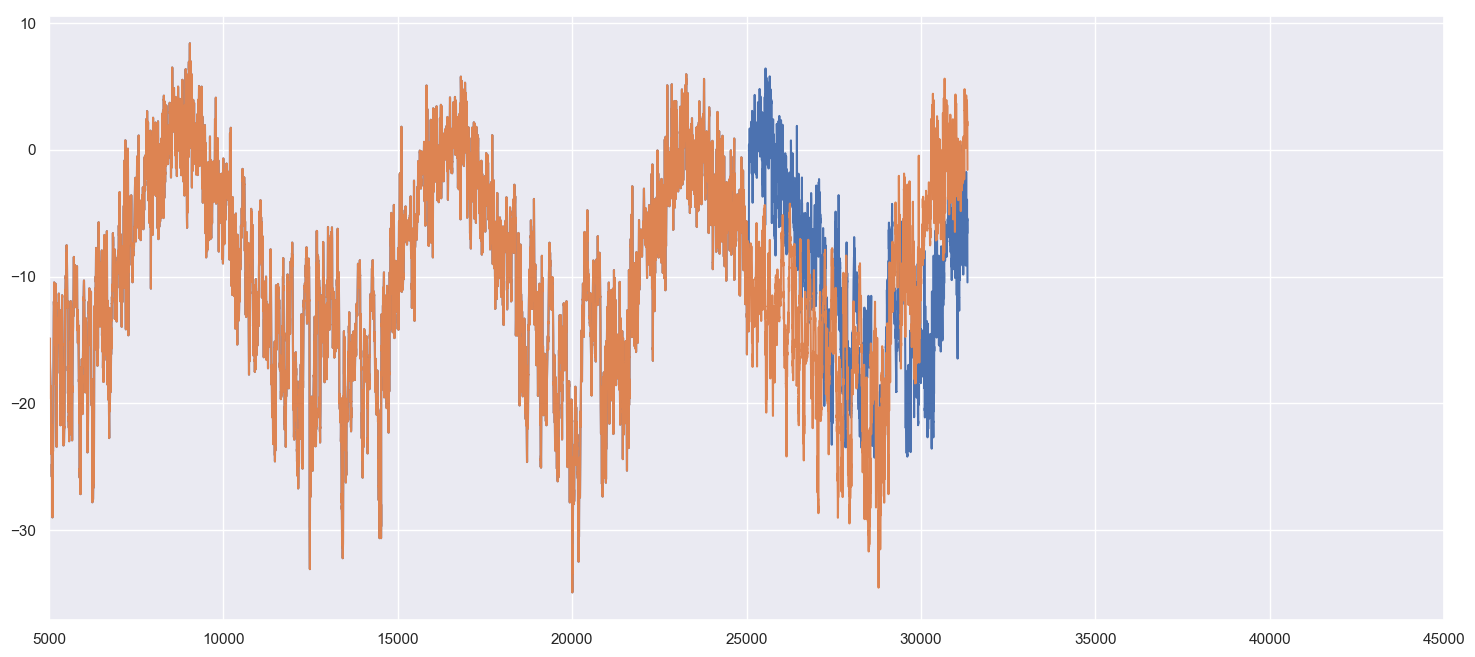

In [18]:
plt.xlim(5000,45000)
plt.plot(temp_values)
plt.plot(df.tempr.values)
plt.show()

In [19]:
print(pred.shape)

(6267,)


In [20]:
print(testX.shape)

(6267,)


In [21]:
RMSE=math.sqrt(mean_squared_error(pred,testX))

In [22]:
print(RMSE)

9.246917286468902
